In [ ]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Francesca Bevilacqua (University of Bologna)
#   Reviewed by:  Margaret Duff (STFC - UKRI )

# Comparison between the Least Square and the Weighted Least Square and the Kullback Leibler Divergence
As we know, the data in computed tomography is affected by Poisson Noise due to the electromagnetic nature of X-rays. The Poisson distribution can be easily approximated by a Gaussian when the mean is high, but it differs from it when the mean is lower. This is the case of Low Dose CT, where the number of photon that reach the detector pixels are less than standard CT. 
Here we briefly summarize the acquisition model:
$$I = I_{0} e^{-Ax}$$
where $I$ is the intensity data collected by the detector, $I_{0}$ is the incoming souce intensity, $A$ is the projection operator of Computed Tomography and $x$ is the object (attenuation coefficients) that we want to reconstruct. When adding the Poisson Noise we have:
$$ B = Poisson (I). $$ 
Most of the standard CT reconstruction strategies work by solving the linear sistem
$$ Y = Ax$$
where $Y = -\log (\frac{B}{I_{0}})$ is the sinogram data (obtained after taking the negative logarithm of $\frac{B}{I_{0}}$). In particular, the least square problem relies on finding $x$ by solving the following minimization problem:
$$ \min_{x} \mathcal{F}(x) := \frac{1}{2} || Y - Ax||_{2}^{2}.$$
Clearly, using this formulation, we are supposing that the distribution of the noise inside $Y$ is a white Gaussian. We know instead that a Poisson distribution on the measurements $B$ is more realistic, but the function to minimize $\mathcal{F}_{P}$ obtained considering $B =Poisson ( I_{0} e^{-Ax})$  is very different from the linear least-square problem for Gaussian Noise. 
In this notebook we compare the least squares approach to a weighted least squares loss and a Kullback Leibler Divergence loss. 

By considering a quadratic approximation of function $\mathcal{F}_{P}$  the problem takes the following form:
$$ \min_{x} \mathcal{F_{W}} : = \frac{1}{2} || Y - Ax ||_{W}^{2} \, \rightarrow \, \min_{x} \frac{1}{2} \sum_{i} w_{i} (Y-Ax)_{i} $$
where $w_{i} = e^{-Y_{i}} = \frac{B}{I_{0}}$. The main difference between $\mathcal{F}$ and $\mathcal{F}_{W}$ is the weight matrix $W$. This is the weighted least squares approach. 

# TODO: explain the KL loss here 


In this notebook we will see the difference between the solution obtained by minimizing $\mathcal{F}$, $\mathcal{F}_{W}$ and TODO: for the case of low dose CT, i.e. where the distribution of the noise is very different from a white gaussian, and the level of the noise is high.

In [1]:
# cil imports
from cil.framework import ImageGeometry, DataContainer
from cil.framework import AcquisitionGeometry
from cil.optimisation.functions import Function


from cil.optimisation.functions import LeastSquares, KullbackLeibler, OperatorCompositionFunction, ZeroFunction
from cil.optimisation.functions import TotalVariation
from cil.optimisation.algorithms import GD, PDHG, FISTA

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP


from cil.plugins import TomoPhantom
from cil.utilities.quality_measures import psnr
from cil.utilities.display import show_geometry
from cil.utilities.display import show2D


import numpy as np
import matplotlib.pyplot as plt


# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'

## CIL version 23.1.0 

In [ ]:
import cil
print(cil.__version__)

## The dataset 

In this notebook we will use a classical Shepp-Logan phantom generated with the [TomoPhantom toolbox](https://github.com/dkazanc/TomoPhantom).

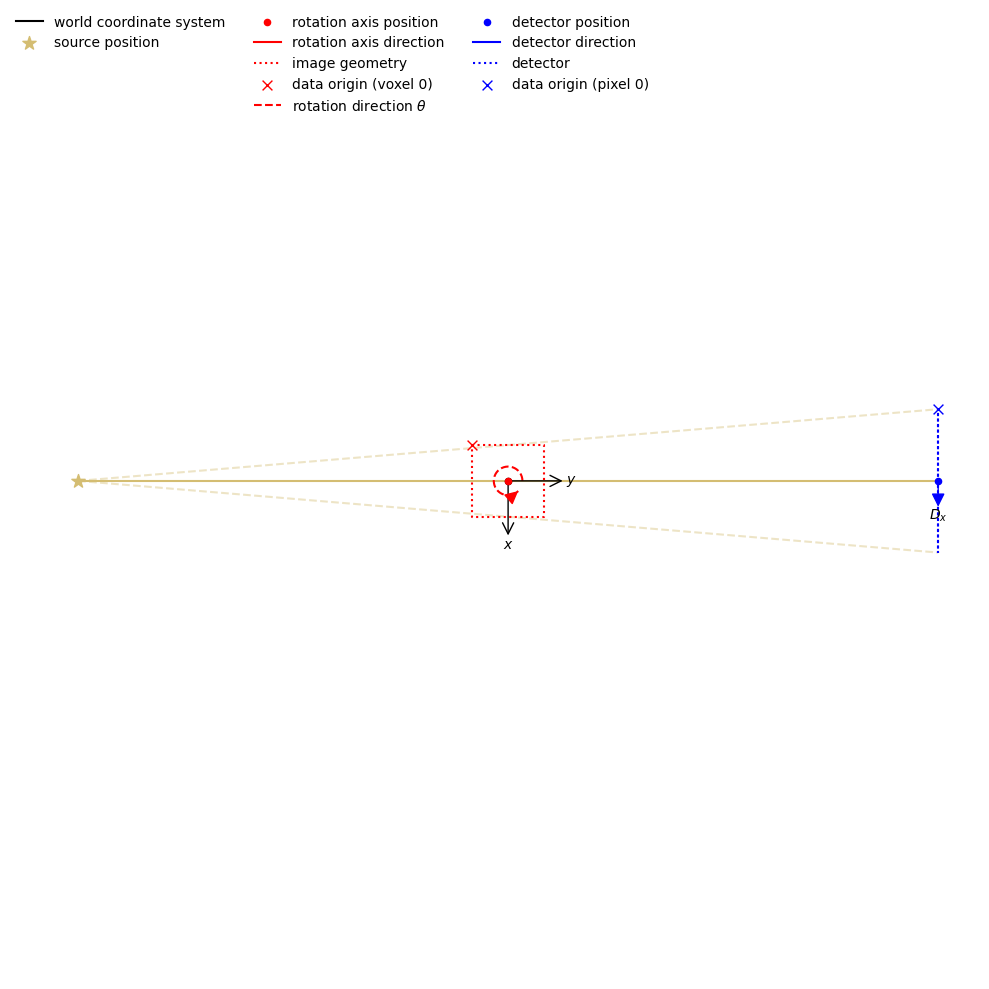

In [4]:
# number of pixels
n_pixels = 256

# Angles
angles = np.linspace(0, 360, 500, endpoint=False, dtype=np.float32)

# set-up fan-beam AcquisitionGeometry
# distance from source to center of rotation
dist_source_center = 6#300.0
# distance from center of rotation to detector
dist_center_detector = 6# 200.0
# physical pixel size
pixel_size_h = 2/n_pixels
#magnification
mag = (dist_source_center + dist_center_detector) / dist_source_center

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Cone2D(source_position=[0,-dist_source_center], detector_position=[0, dist_center_detector])
ag.set_angles(angles=angles)
ag.set_panel(num_pixels=n_pixels, pixel_size=(pixel_size_h, pixel_size_h))

# Setup image geometry
ig = ImageGeometry(voxel_num_x=n_pixels, 
                   voxel_num_y=n_pixels, 
                   voxel_size_x=ag.pixel_size_h / mag, 
                   voxel_size_y=ag.pixel_size_h / mag)
show_geometry(ag)
phantom = TomoPhantom.get_ImageData(num_model=1, geometry=ig)

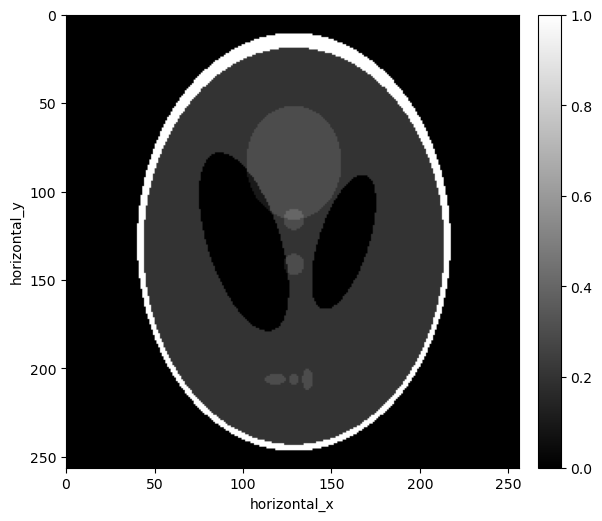

In [5]:
phantom.array[phantom.array<0] = 0
# Visualise data
show2D(phantom, cmap=cmap, num_cols=1, size=(10,10), origin='upper-left')


Next, we create our simulated tomographic data by projecting our noiseless phantom to the acquisition space.

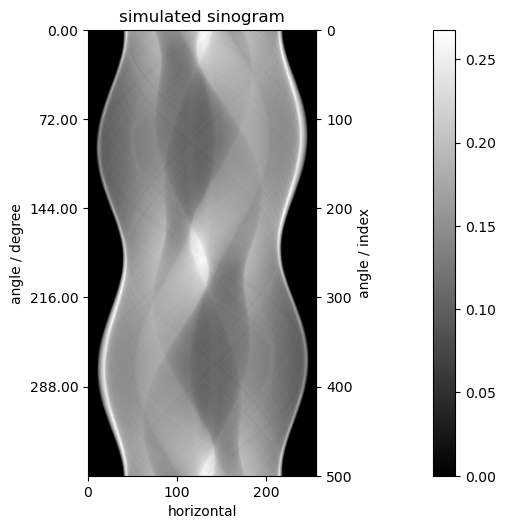

In [6]:
# Create projection operator using Astra-Toolbox.
A = ProjectionOperator(ig, ag, device)

# Create an acqusition data (numerically)
sino = A.direct(phantom)
#print(np.min(sino))

# Visualise data
show2D(sino, 'simulated sinogram', cmap=cmap, size=(10,10), origin='upper-left')

17.98269546012552


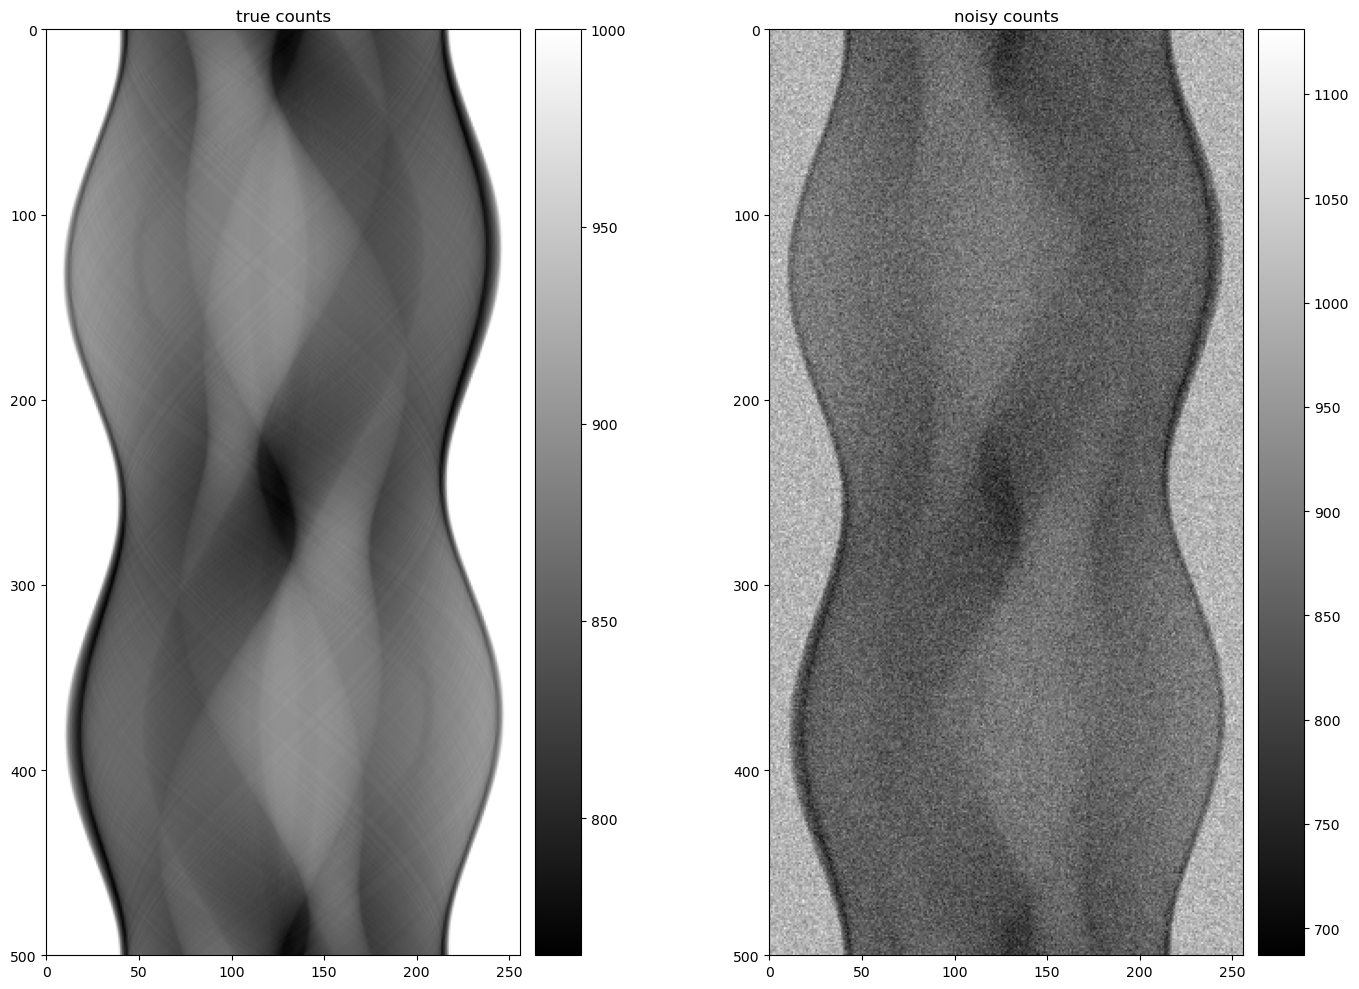

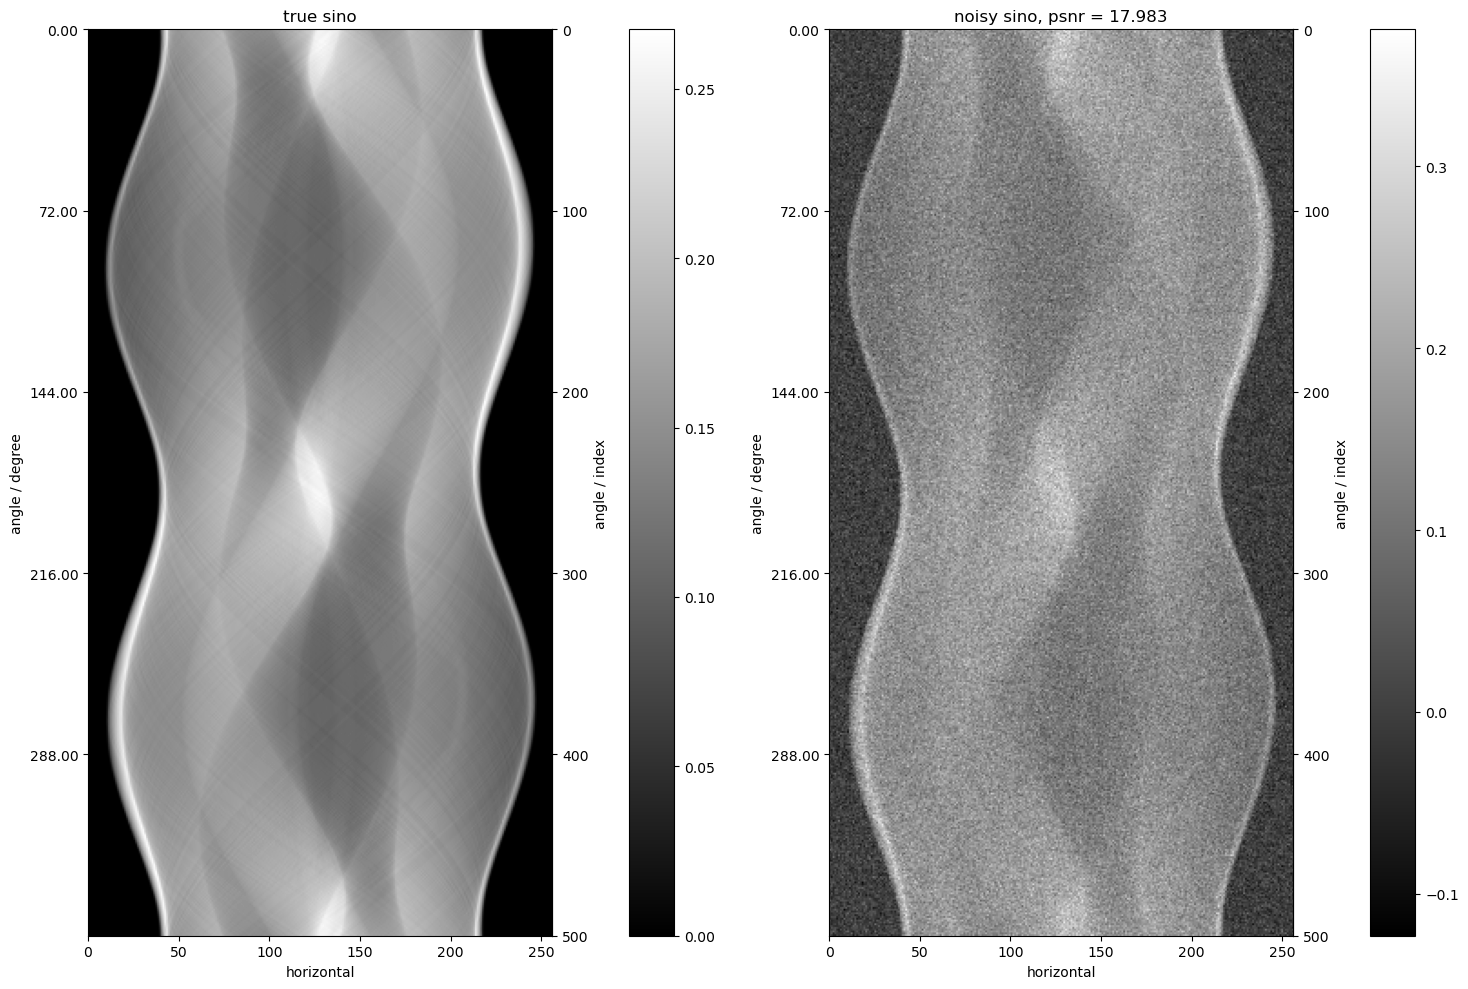

In [7]:
# Incident intensity: lower counts will increase the noise
background_counts = 1000 

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sino.as_array())
tmp = np.exp(-sino.as_array())
noisy_counts = np.random.poisson(counts)
nonzero = noisy_counts > 0
sino_out = np.zeros_like(sino.as_array())
sino_out[nonzero] = -np.log(noisy_counts[nonzero] / background_counts)


# allocate sino_noisy and fill with noisy data
sino_noisy = ag.allocate()
sino_noisy.fill(sino_out)


psnr_sino = psnr(sino, sino_noisy, data_range = np.max(sino))
print(psnr_sino)

# Visualize the true and noisy data
show2D([counts, noisy_counts], ['true counts', 'noisy counts'], \
       cmap=cmap, num_cols=2, size=(15,10), origin='upper-left')
## Visualize the true and noisy data
show2D([sino, sino_noisy], ['true sino', "noisy sino, psnr = %5.3f" % (psnr_sino)], \
       cmap=cmap, num_cols=2, size=(15,10), origin='upper-left')
#plt.savefig("Sinogram_I0_%7.f.png" %(background_counts))

# Reconstruct the noisy data using FBP

In [8]:
# reconstruct full data
# configure FBP
fbp = FBP(ig, ag, device)
# run on the AcquisitionData
recon_fbp = fbp(sino_noisy)
psnr_fbp = psnr(phantom,recon_fbp, np.max(phantom))
#print(psnr_fbp)

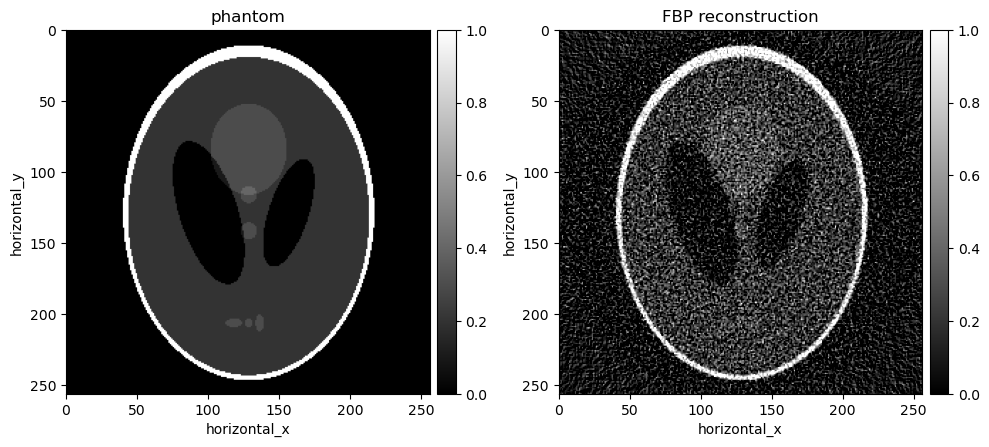

In [9]:
show2D([phantom, recon_fbp], ['phantom', 'FBP reconstruction'], \
       cmap=cmap, fix_range=(0,1),num_cols=2, size=(10,10), origin='upper-left')




# Reconstructing the noisy data using LS TV and WLS TV  (with FISTA)
In addition to the least-square or weighted least square term, we considered a Total Variation Regularizer.
So, for the LS-TV problem, we want to minimize the following:
$$ ||Y-Ax||_{2}^{2} + \alpha \, TV(x) $$
while for the WLS-TV problem we minimize:
$$ ||Y-Ax||_{W}^{2} + \alpha \, TV(x) $$
where $\alpha$ is the regularization parameter that balances the two terms

## Least Squares - TV

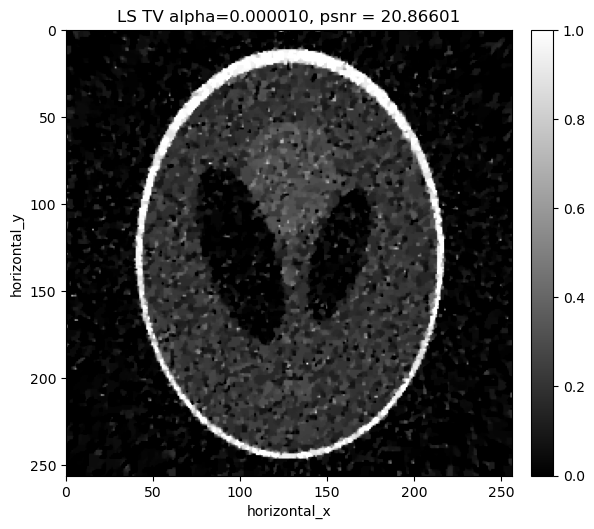

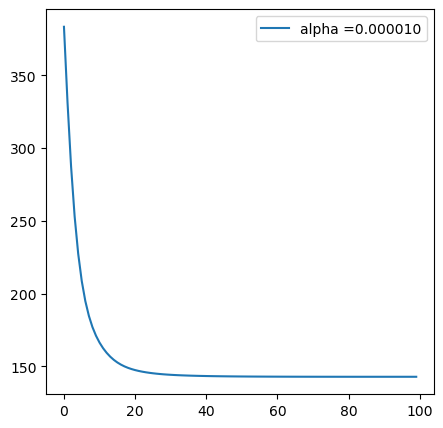

alpha=0.000010, psnr= 20.866
alpha=0.000012, psnr= 22.686


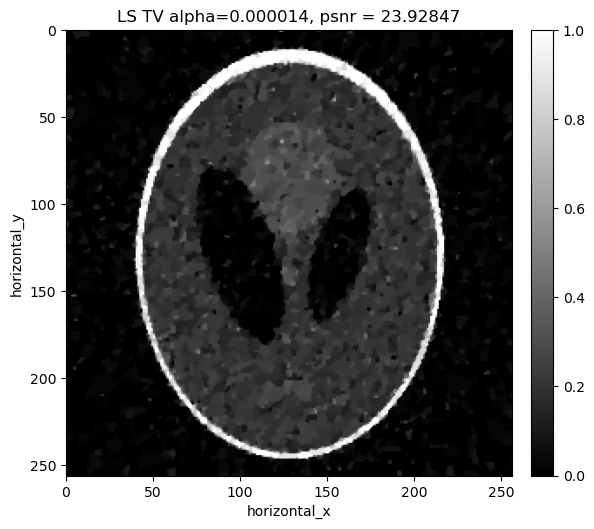

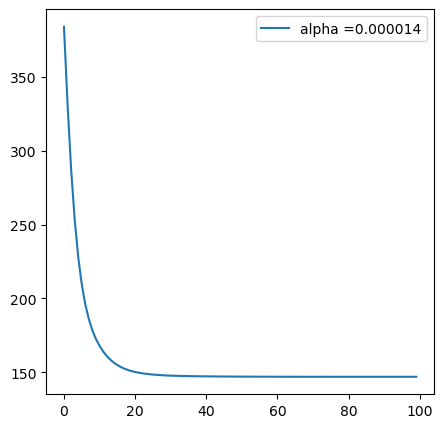

alpha=0.000014, psnr= 23.928
alpha=0.000016, psnr= 24.731


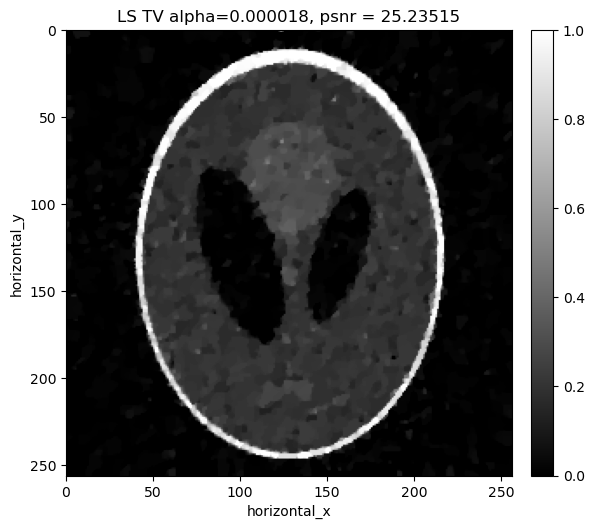

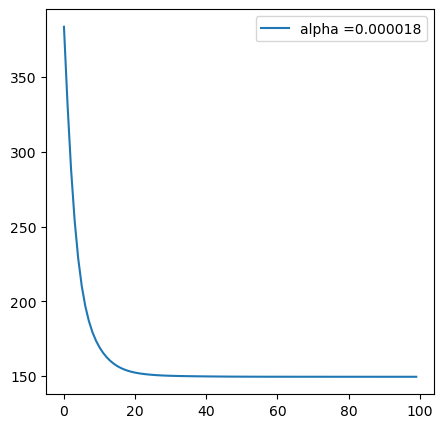

alpha=0.000018, psnr= 25.235
alpha=0.000021, psnr= 25.536


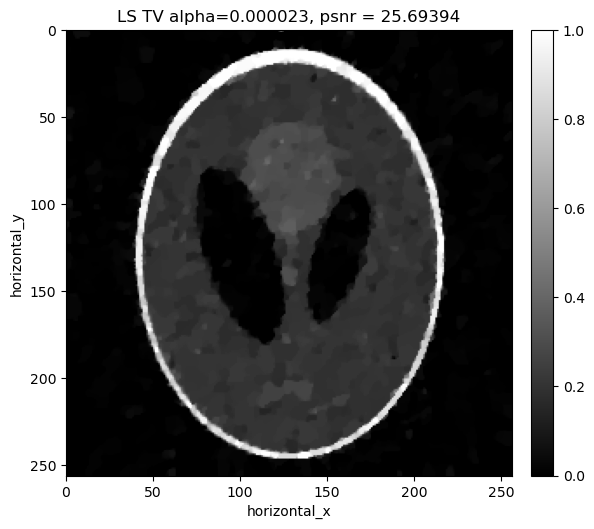

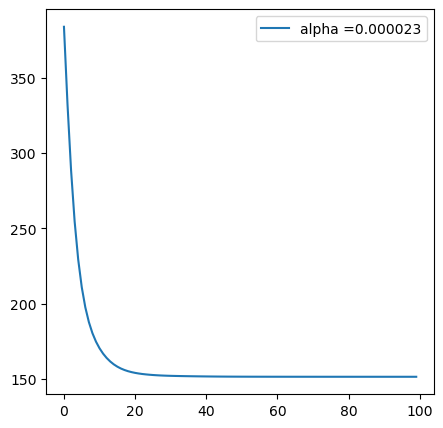

alpha=0.000023, psnr= 25.694
alpha=0.000025, psnr= 25.754


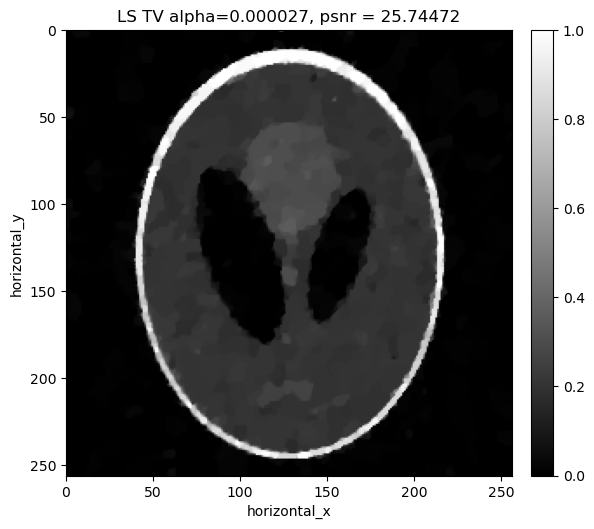

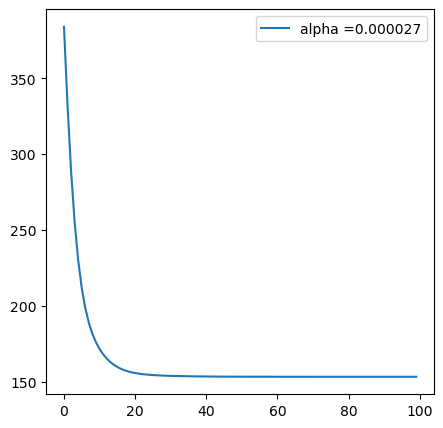

alpha=0.000027, psnr= 25.745
alpha=0.000029, psnr= 25.688


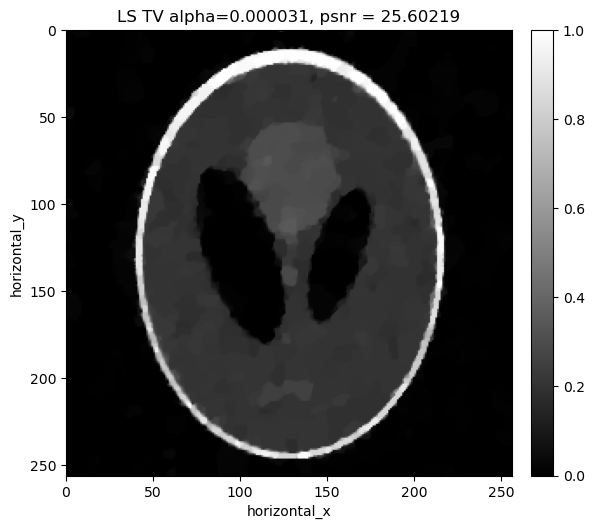

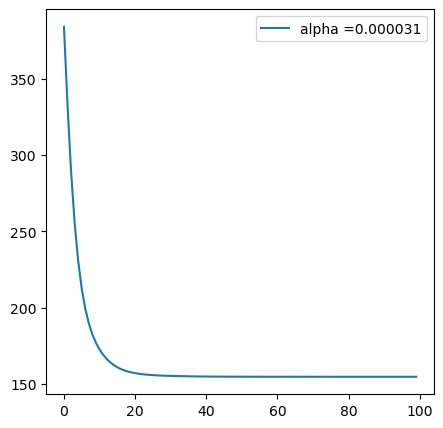

alpha=0.000031, psnr= 25.602
alpha=0.000033, psnr= 25.494


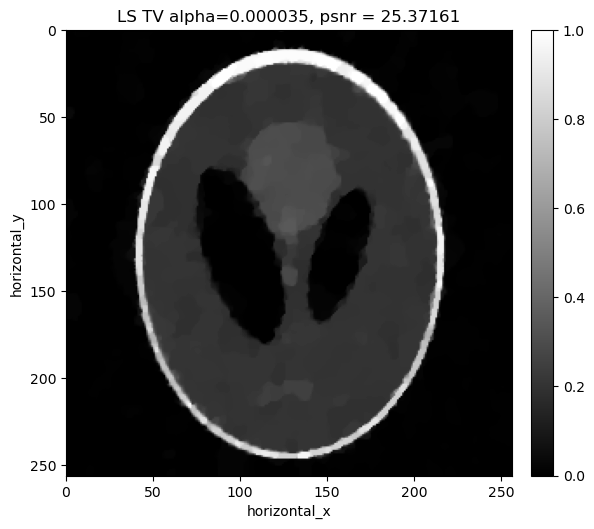

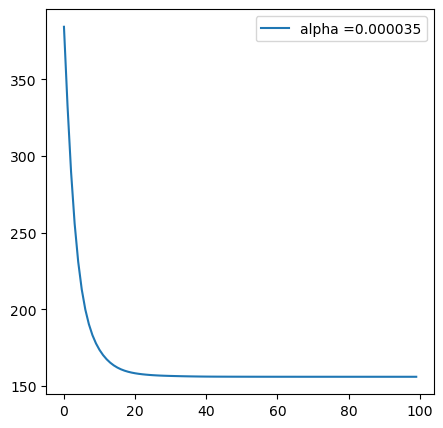

alpha=0.000035, psnr= 25.372
alpha=0.000037, psnr= 25.241


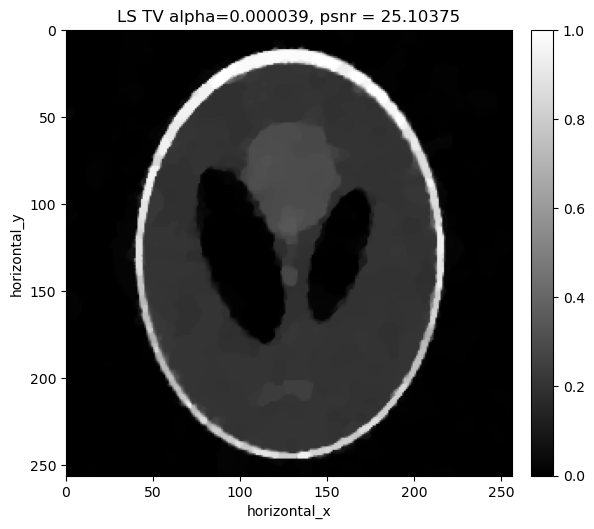

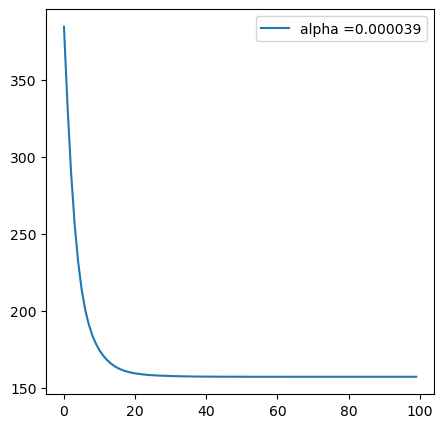

alpha=0.000039, psnr= 25.104
alpha=0.000042, psnr= 24.964


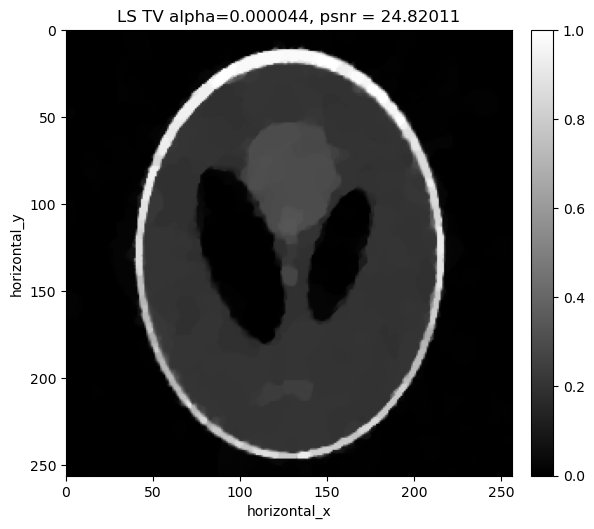

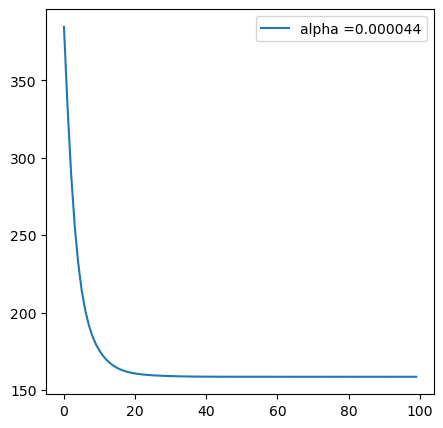

alpha=0.000044, psnr= 24.820
alpha=0.000046, psnr= 24.676


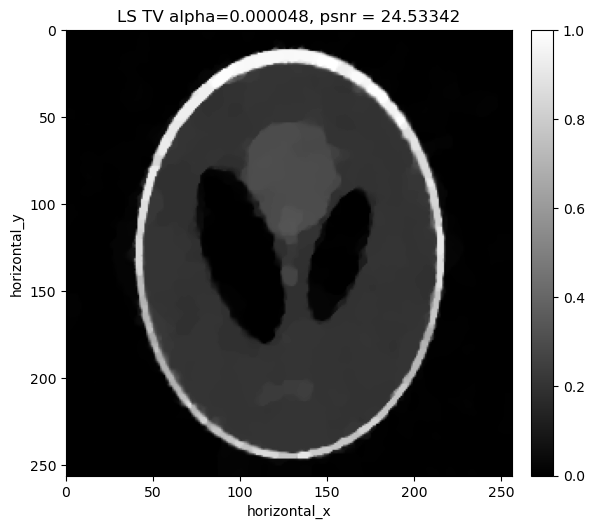

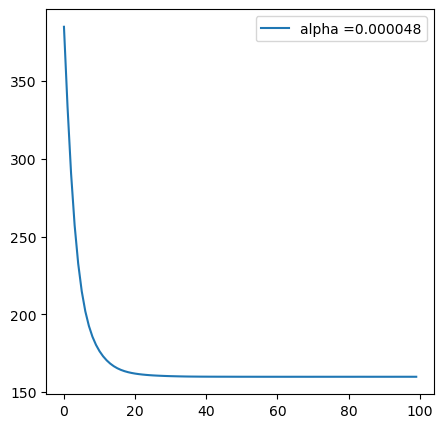

alpha=0.000048, psnr= 24.533
alpha=0.000050, psnr= 24.393


In [11]:
# Selection of the best regularization parametr using LS TV - FISTA
alpha_min = 0.00001
alpha_max = 0.00005
alpha_n   = 20
alphas_ls    = np.linspace(alpha_min, alpha_max, alpha_n) 
modulo    = 2 #how often to plot the reconstructions, for the different values of alpha

#Definition of the fidelity term
f3 = LeastSquares(A, sino_noisy)

#Initialize quantities
x0 = ig.allocate(0.0)
psnr_ls_tv_alpha = np.zeros_like(alphas_ls)
max_psnr = 0

# Run the loop over the different values of alpha
for i in range(alpha_n):
    alpha = alphas_ls[i]
    # Defining the regularization term with the new alpha
    GTV = alpha*TotalVariation()
    # Setting up FISTA
    myFISTATV = FISTA(f=f3, 
                  g=GTV, 
                  x_init=x0 ,
                  max_iteration=100, initial=ig.allocate(0))
    # Run FISTA
    myFISTATV.run(100, verbose=0)
    recon_ls_tv = myFISTATV.solution
    psnr_ls_tv_alpha[i] = psnr(phantom,recon_ls_tv, data_range = np.max(phantom))
    
 
    
    # Save the reconstruction (one every "modulo")
    if i%modulo == 0:
        show2D([recon_ls_tv], ["LS TV alpha=%7.6f, psnr = %7.5f" % (alpha,psnr_ls_tv_alpha[i])], cmap=cmap,fix_range=(0,1), size=(10,10), origin='upper-left')
         # plot the objective function
        plt.figure(figsize=(5,5))
        plt.plot( myFISTATV.objective[1:],label="alpha =%7.6f" % (alpha))
        plt.legend(fontsize=10)
        plt.show()
            
    # print the value of alpha and the obtained psnr of the reconstruction
    print("alpha=%7.6f, psnr= %5.3f" % (alpha,psnr_ls_tv_alpha[i]))
    
    # Save the best reconstruction
    if psnr_ls_tv_alpha[i]>max_psnr:
        max_psnr   = psnr_ls_tv_alpha[i]
        best_recon = recon_ls_tv
        best_alpha = alpha
        

In [12]:
recon_ls_tv_fista = best_recon
psnr_ls_tv_fista  = max_psnr
alpha_ls_tv_fista = best_alpha

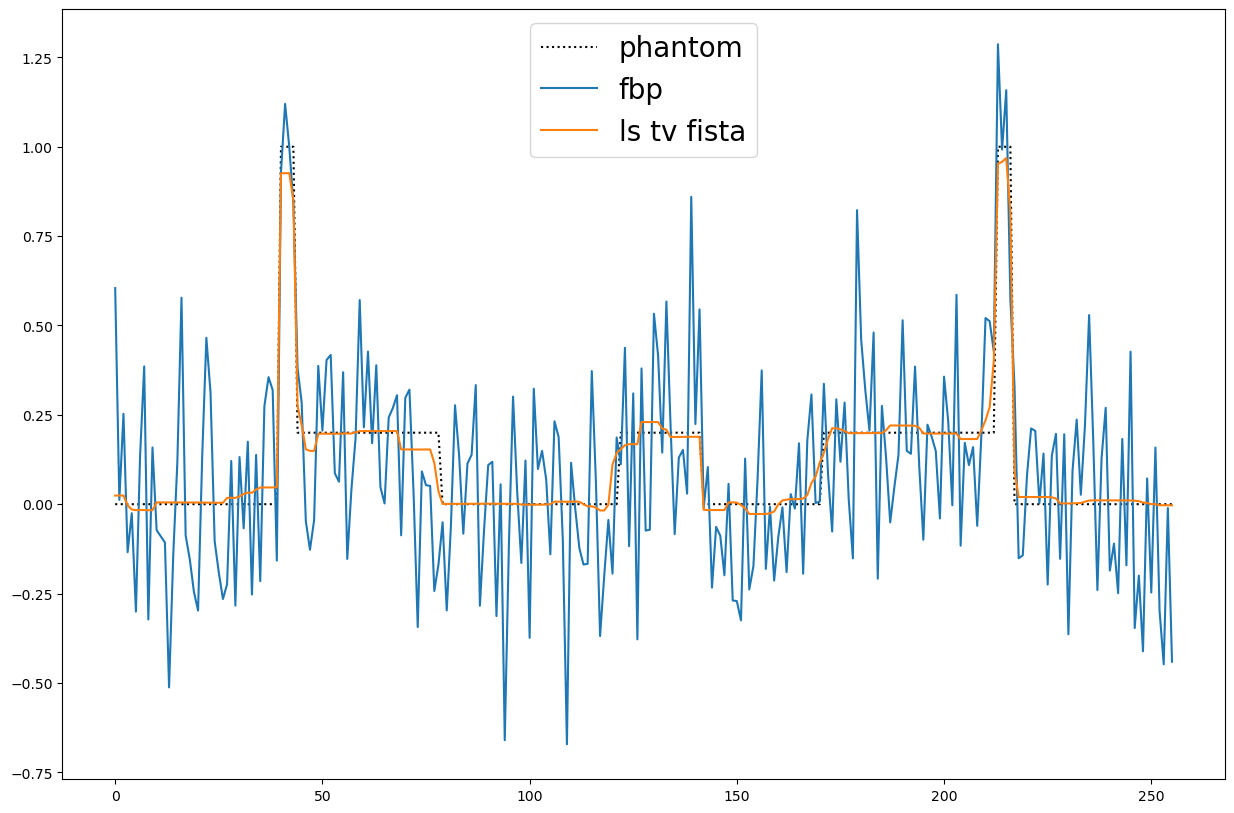

In [13]:
linenumy=128
plt.figure(figsize=(15,10))
plt.plot(phantom.get_slice(horizontal_y=linenumy).as_array(),':k',label="phantom")
plt.plot(recon_fbp.get_slice(horizontal_y=linenumy).as_array(),label="fbp")
plt.plot(recon_ls_tv_fista.get_slice(horizontal_y=linenumy).as_array(),label="ls tv fista")
plt.legend(fontsize=20)
plt.show()

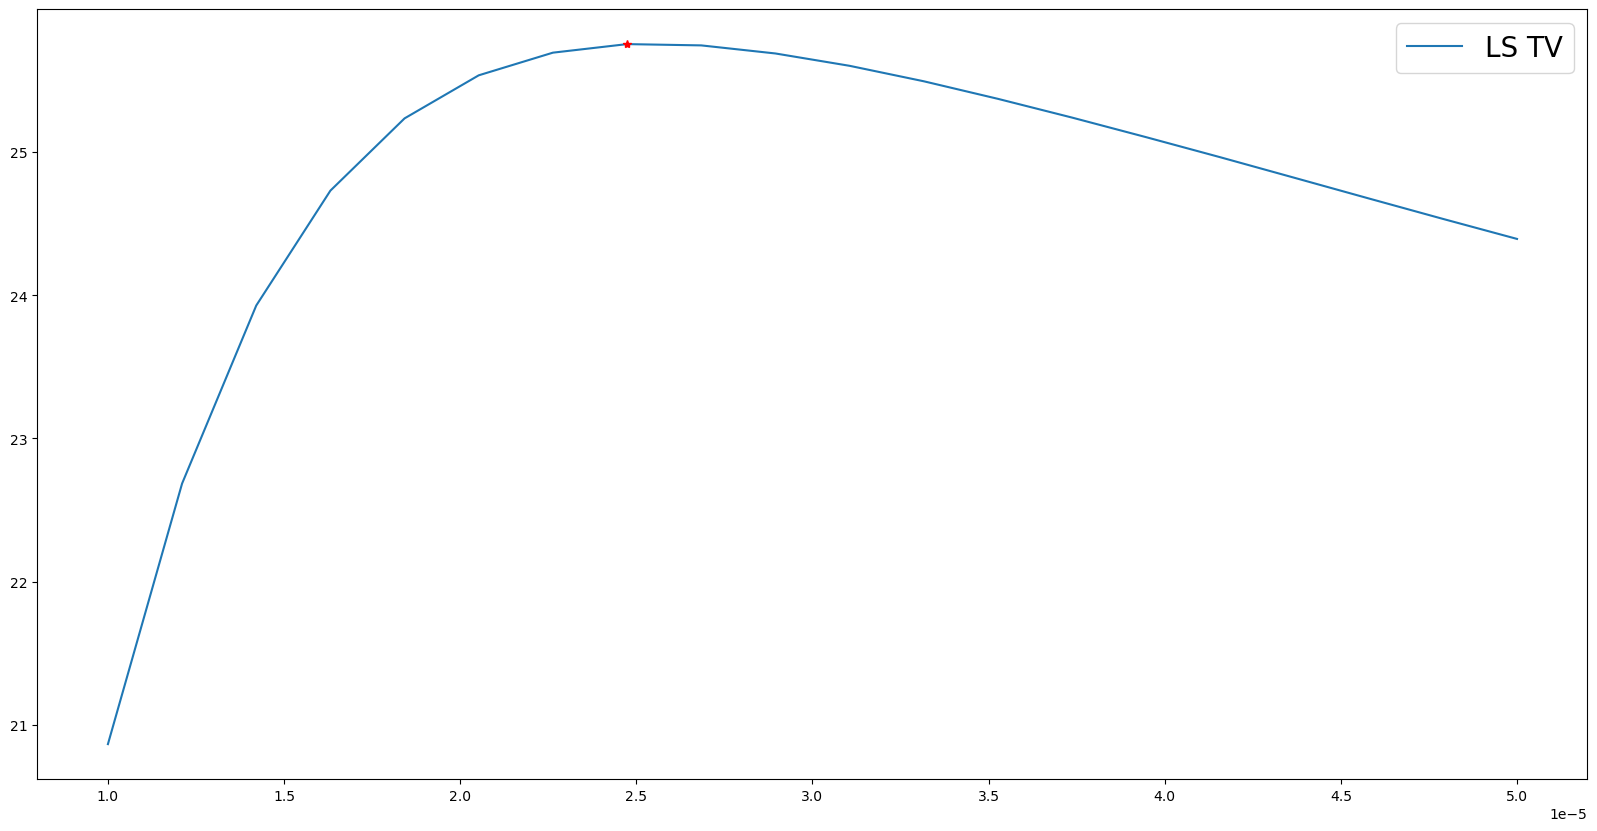

In [14]:
# PSNR for different values of alpha
plt.figure(figsize=(20,10))
plt.plot(alphas_ls,psnr_ls_tv_alpha,label="LS TV")
plt.plot(alpha_ls_tv_fista, psnr_ls_tv_fista, '*r')
plt.legend(fontsize=20)
plt.show()


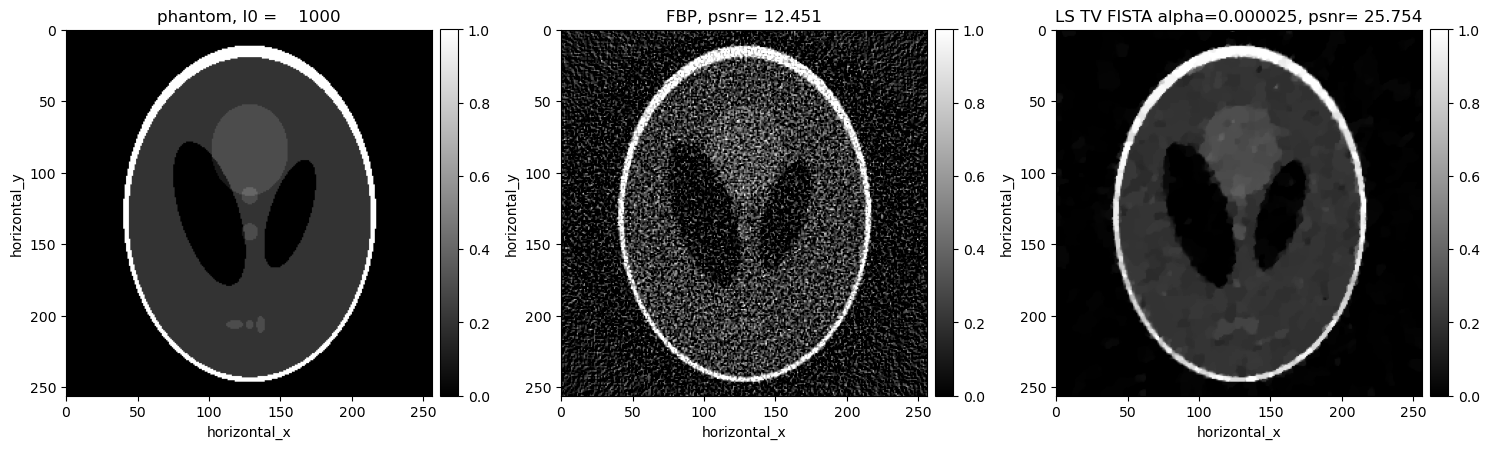

In [15]:
# get and visusualise the results
show2D([phantom, recon_fbp, recon_ls_tv_fista ], ["phantom, I0 = %7.0f" % (background_counts), "FBP, psnr= %5.3f" % (psnr_fbp),\
    "LS TV FISTA alpha=%7.6f, psnr= %5.3f" % (alpha_ls_tv_fista,psnr_ls_tv_fista)], \
       cmap=cmap, fix_range =(0,1), num_cols=3, size=(15,10), origin='upper-left')


## Weighted Least Squares 

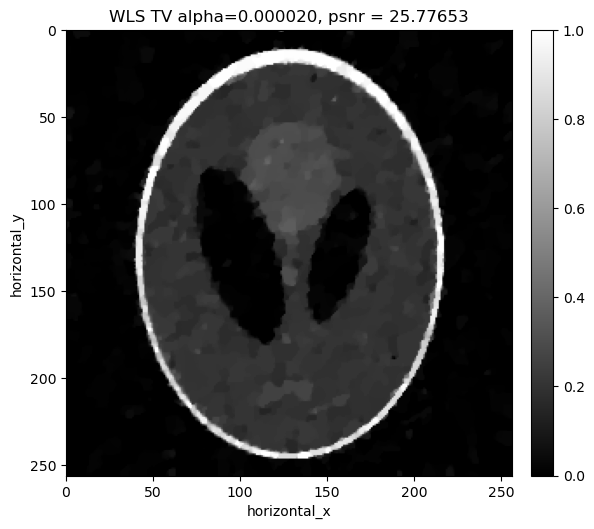

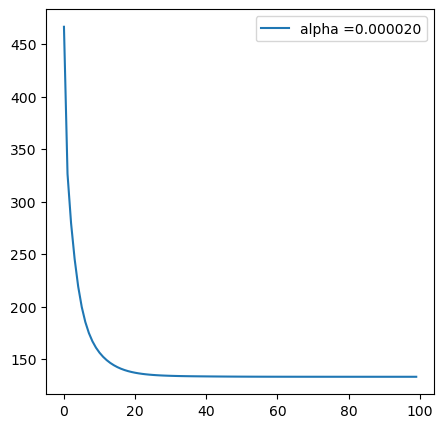

alpha=0.000020, psnr= 25.777
alpha=0.000022, psnr= 25.826


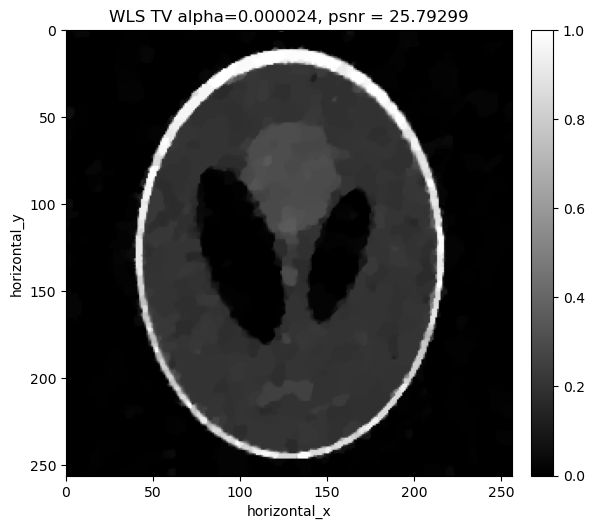

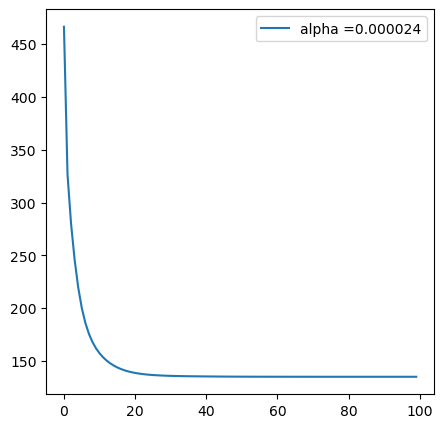

alpha=0.000024, psnr= 25.793
alpha=0.000026, psnr= 25.706


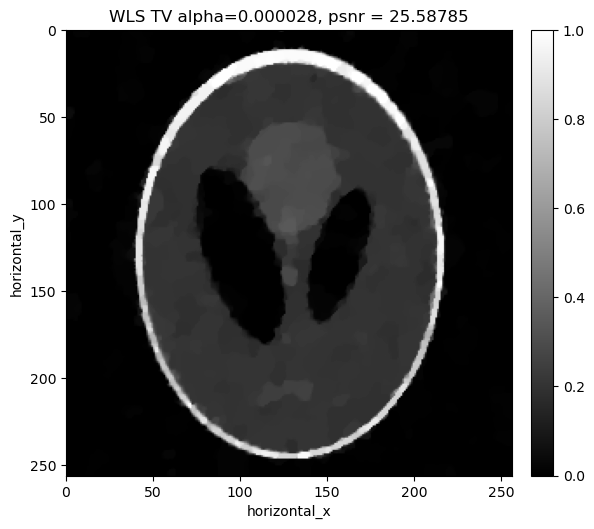

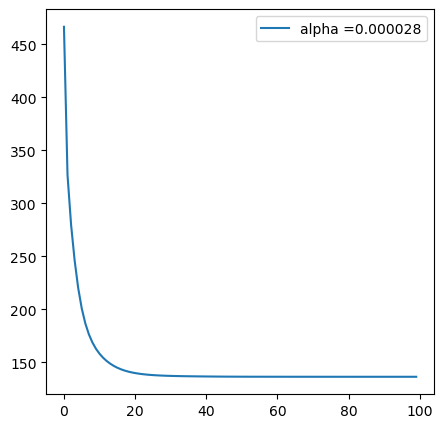

alpha=0.000028, psnr= 25.588
alpha=0.000031, psnr= 25.445


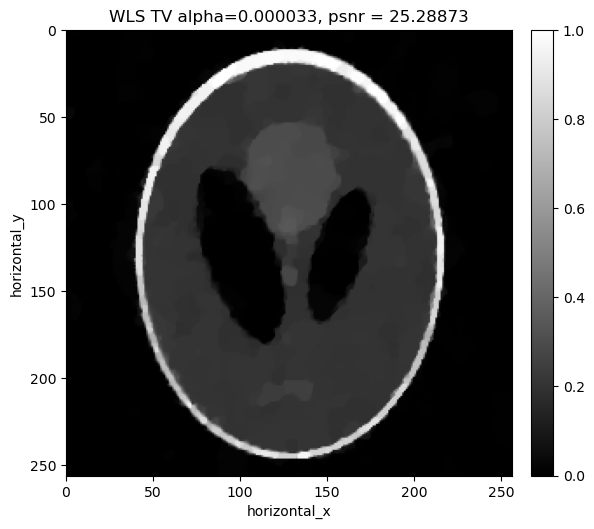

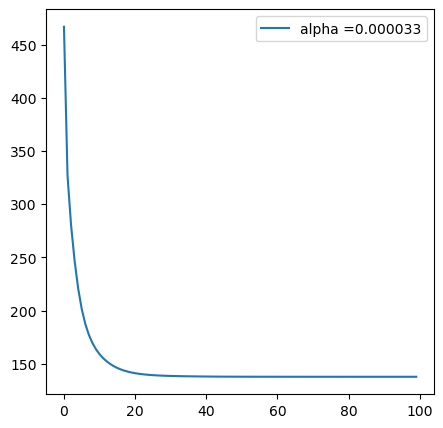

alpha=0.000033, psnr= 25.289


KeyboardInterrupt: 

In [31]:
# Selection of the best regularization parameter using WLS TV - FISTA
alpha_min = 0.00002
alpha_max = 0.00006
alpha_n   = 20
alphas_wls   = np.linspace(alpha_min, alpha_max, alpha_n) 
modulo    = 2 #10 #how often to plot reconstructions, for the different values of alpha

#Definition of the fidelity term
weights = noisy_counts/background_counts
c = ag.allocate(0)
c.fill(weights)
WF = LeastSquares(A, sino_noisy, 1,c)

#Initialize quantities
x0 = ig.allocate(0.0)
psnr_wls_tv_alpha = np.zeros_like(alphas_wls)
w_max_psnr = 0

# Run the loop over the different values of alpha
for i in range(alpha_n):
    alpha = alphas_wls[i]
    # Defining the regularization term with the new alpha
    GTV = alpha*TotalVariation()
    # Setting up FISTA
    myFISTAWTV = FISTA(f=WF, 
                  g=GTV, 
                  x_init=x0 ,
                  max_iteration=100, initial=ig.allocate(0))
    # Run FISTA
    myFISTAWTV.run(100, verbose=0)
    recon_wls_tv = myFISTAWTV.solution
    psnr_wls_tv_alpha[i] = psnr(phantom,recon_wls_tv, data_range = np.max(phantom))

    # Plot the reconstruction (one every "modulo")
    if i%modulo == 0:
        
        # plot the reconstruction 
        show2D([recon_wls_tv], ["WLS TV alpha=%7.6f, psnr = %7.5f" % (alpha,psnr_wls_tv_alpha[i])], \
        cmap=cmap,fix_range=(0,1), size=(10,10), origin='upper-left')
        # plot the objective function
        plt.figure(figsize=(5,5))
        plt.plot( myFISTAWTV.objective[1:],label="alpha =%7.6f" % (alpha))
        plt.legend(fontsize=10)
        plt.show()
        
        
    # print the value of alpha and the obtained psnr of the reconstruction
    print("alpha=%7.6f, psnr= %5.3f" % (alpha,psnr_wls_tv_alpha[i]))
    
    # Save the best reconstruction
    if psnr_wls_tv_alpha[i]>w_max_psnr:
        w_max_psnr   = psnr_wls_tv_alpha[i]
        w_best_recon = recon_wls_tv
        w_best_alpha = alpha

In [ ]:
recon_wls_tv_fista = w_best_recon
psnr_wls_tv_fista  = w_max_psnr
alpha_wls_tv_fista = w_best_alpha
print(psnr_wls_tv_fista)

25.776527967154248


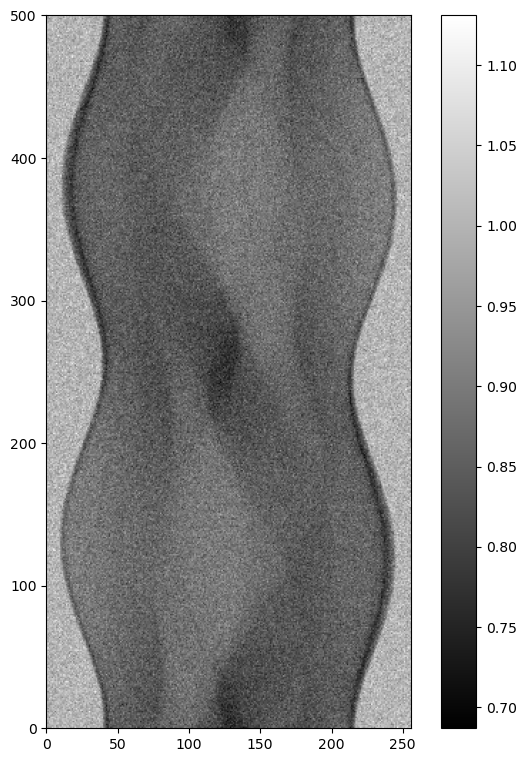

0.687
1.131


In [ ]:
show2D(weights)
print(np.min(weights))
print(np.max(weights))

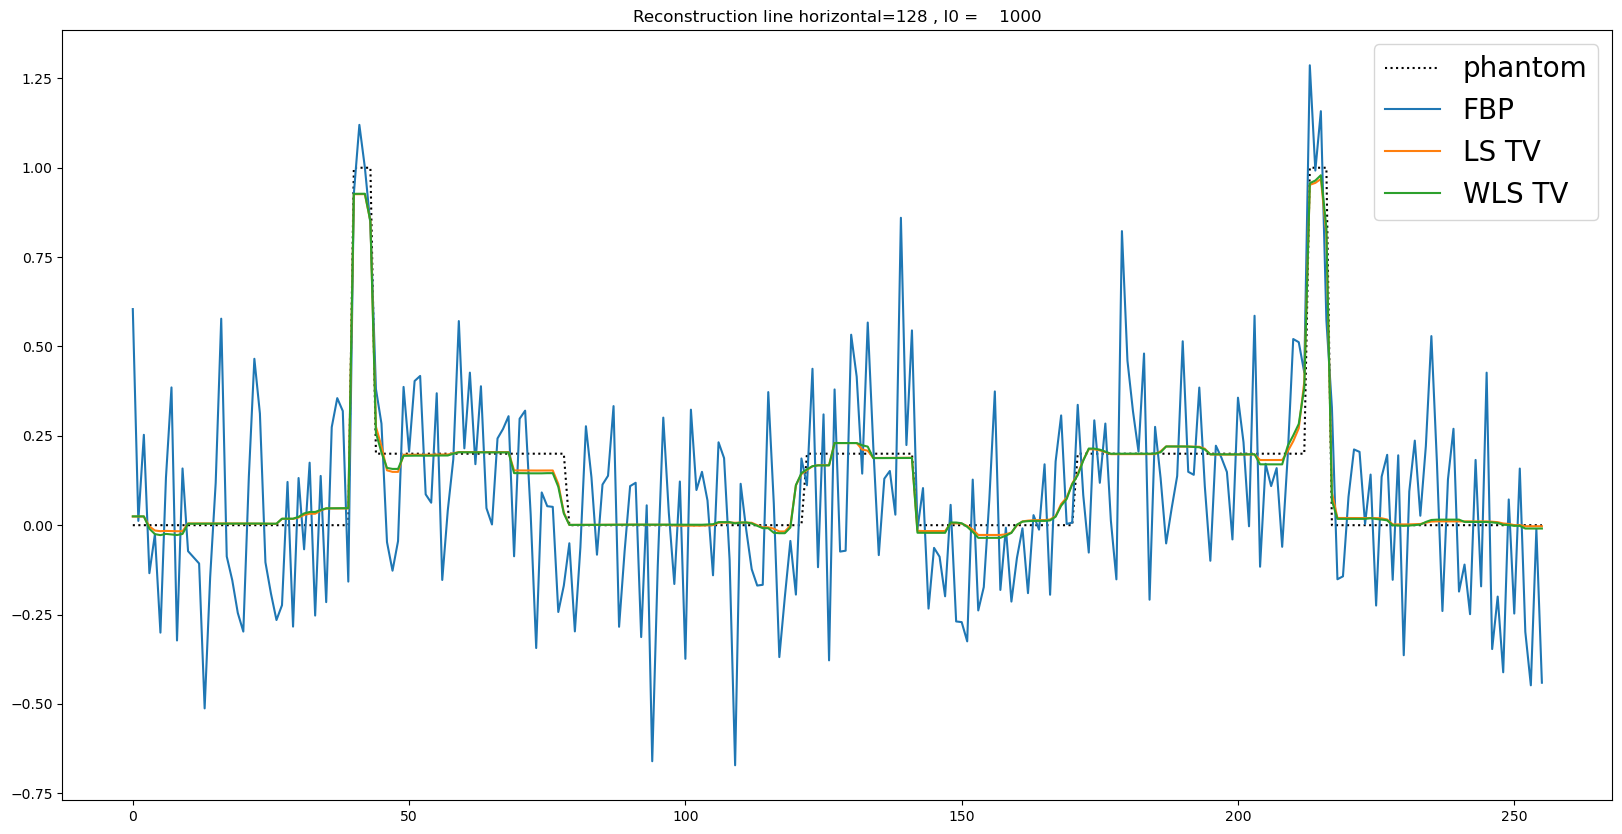

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(phantom.get_slice(horizontal_y=linenumy).as_array(),':k',label="phantom")
plt.plot(recon_fbp.get_slice(horizontal_y=linenumy).as_array(),label="FBP")
plt.plot(recon_ls_tv_fista.get_slice(horizontal_y=linenumy).as_array(),label="LS TV")
plt.plot(recon_wls_tv_fista.get_slice(horizontal_y=linenumy).as_array(),label="WLS TV")
plt.legend(fontsize=20)
plt.title("Reconstruction line horizontal=%3.0f , I0 = %7.f" % (linenumy,background_counts))
plt.show()

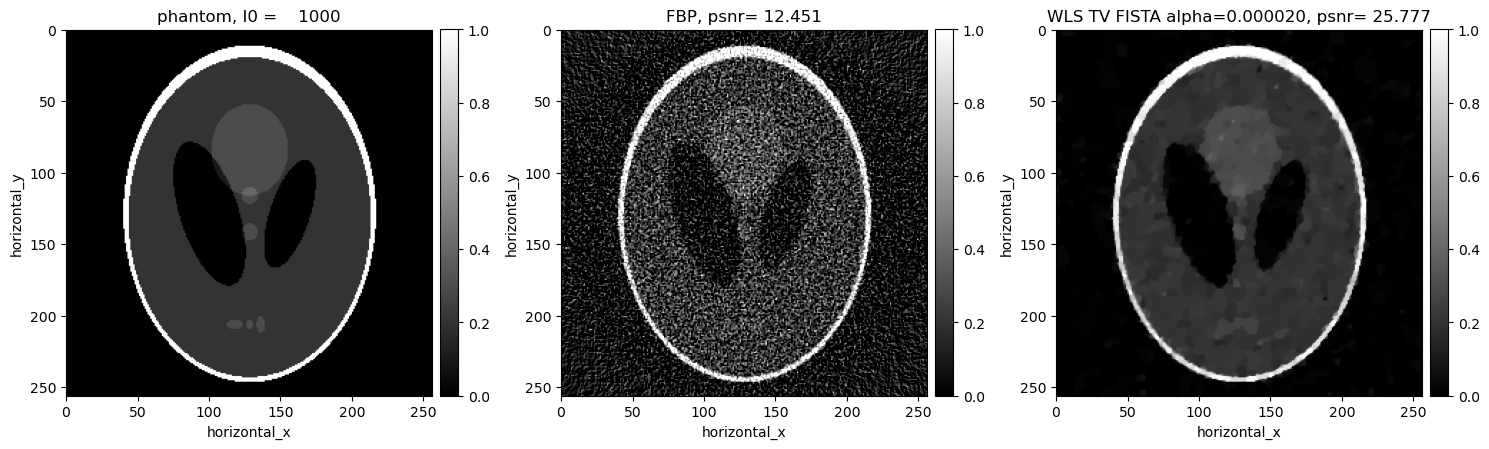

In [ ]:
show2D([phantom, recon_fbp, recon_wls_tv_fista ], ["phantom, I0 = %7.0f" % (background_counts), "FBP, psnr= %5.3f" % (psnr_fbp),\
    "WLS TV FISTA alpha=%7.6f, psnr= %5.3f" % (alpha_wls_tv_fista,psnr_wls_tv_fista)], \
       cmap=cmap, fix_range =(0,1), num_cols=3, size=(15,10), origin='upper-left')


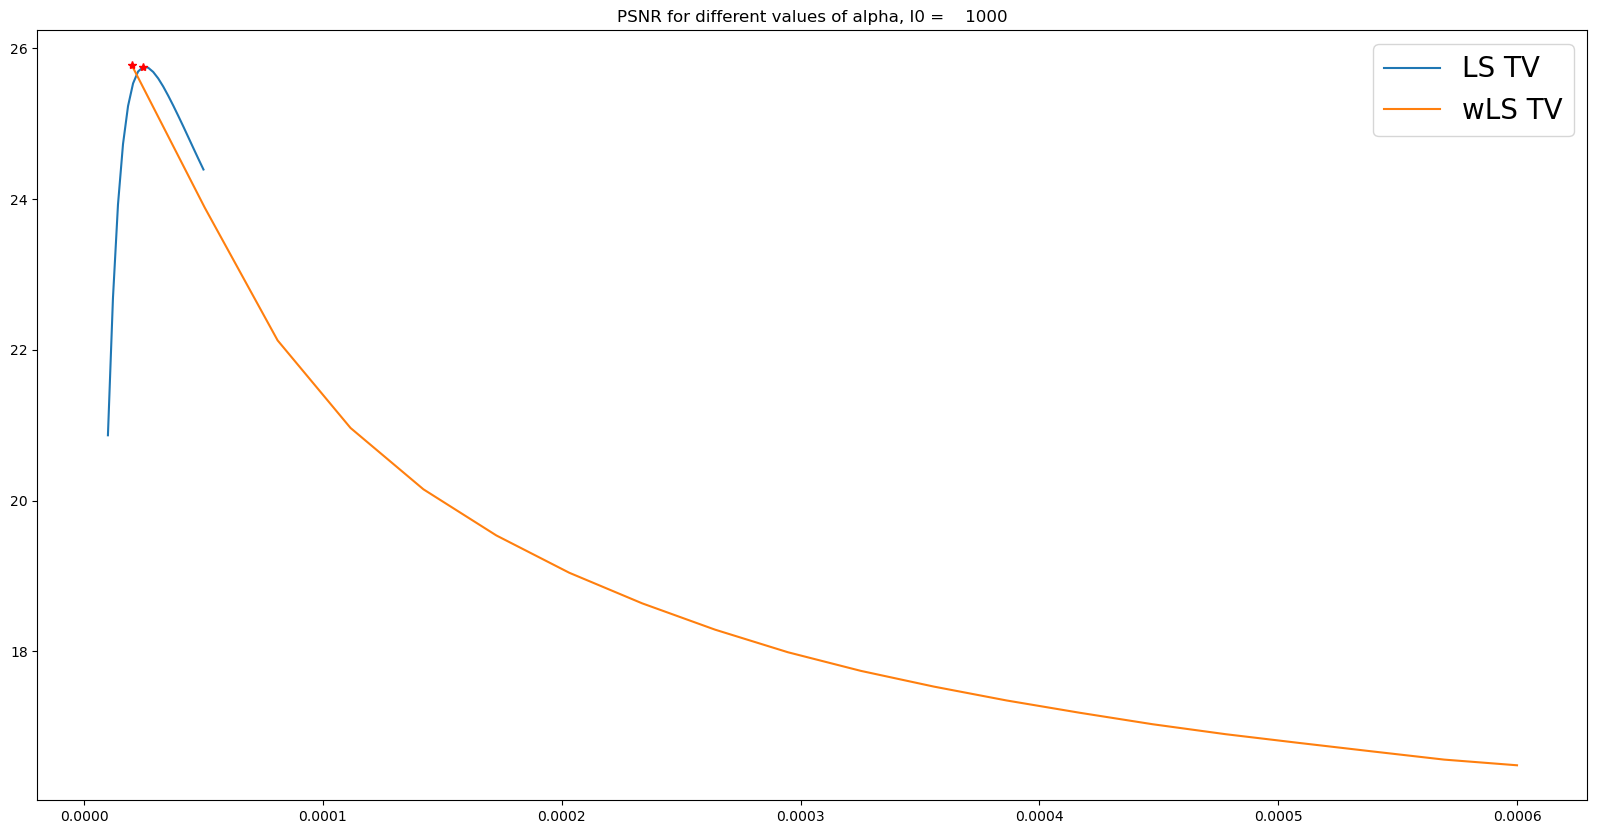

In [ ]:
# PSNR for different values of alpha
plt.figure(figsize=(20,10))
plt.plot(alphas_ls,psnr_ls_tv_alpha,label="LS TV")
plt.plot(alphas_wls,psnr_wls_tv_alpha,label="wLS TV")
plt.plot(alpha_ls_tv_fista, psnr_ls_tv_fista, '*r')
plt.plot(alpha_wls_tv_fista, psnr_wls_tv_fista, '*r')
plt.legend(fontsize=20)
plt.title("PSNR for different values of alpha, I0 = %7.f" % (background_counts))
plt.show()



# Defining the KL fidelity term before the logaritm
The KL function of $u$ and $v$, where $u = \mathrm{Poiss}(v)$ is the following $ KL(u,v) = u \log(\frac{u}{v})-u+v$
Considering $$b = \mathrm{Poiss}(I_{0} e^{(-Ax)})$$
we can define:
$$KL(b,I_{0} e^{(-Ax)}) = \sum_{i} \bigg[b_{i} \log (\frac{b_{i}}{I_{0} e^{-(Ax)_{i}}}) - b_{i} + I_{0} e^{-(Ax)_{i}}\bigg] = 
\sum_{i} \bigg[ b_{i}\log(b_{i}) - b_{i} \log(I_{0}) - b_{i} \log(I_{0} e^{-(Ax)_{i}}) - b_{i} + I_{0} e^{-(Ax)_{i}} \bigg]$$
We want to minimize the KL function with respect to $x$, so we consider
$$KL(b,I_{0} e^{(-Ax)}) = \sum_{i} \bigg[ b_{i} (Ax)_{i} + I_{0} e^{-(Ax)_{i}}\bigg] = \sum_{i} \bigg[ \frac{b_{i}}{I_{0}}(Ax)_{i} + e^{-(Ax)_{i}}\bigg]$$

In [ ]:
#Defining the KL fidelity term 
class KL_prelog(Function):
    def __init__(self, d):
        super(KL_prelog, self).__init__(L=1)
        self.d  = d   # d = b/I0
        
    #@property
    #def L(self): 
    #    return 0.00001

    def __call__(self, x):
        vec = x.as_array()
        res = self.d*vec+np.exp(-vec)
        return np.sum(res)


    def gradient(self, x, out=None):
        vec  = x.as_array()
        der  = self.d-np.exp(-vec)
        #res2 = np.sum(der)
        if out is not None:
            out.fill (der)
        else:
            return der

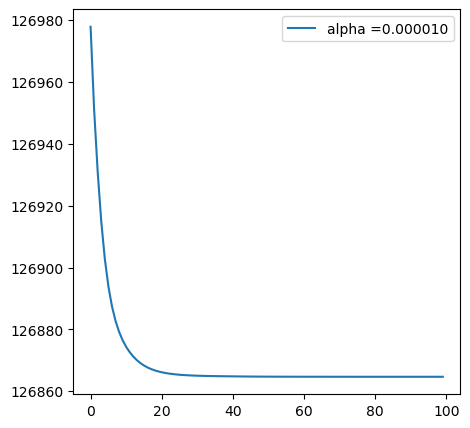

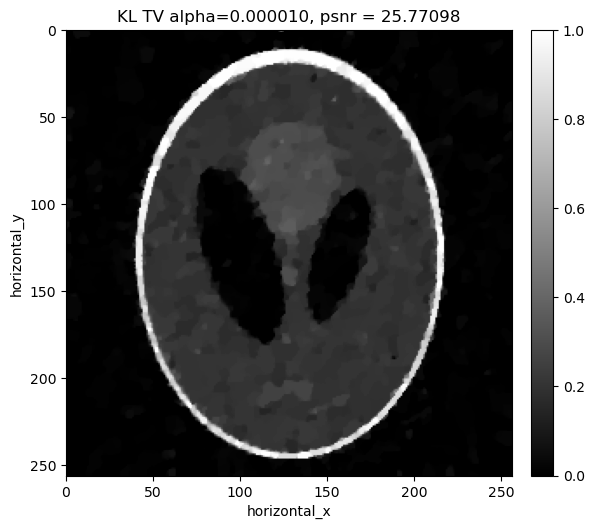

alpha=0.000010, psnr= 25.771
alpha=0.000012, psnr= 25.789


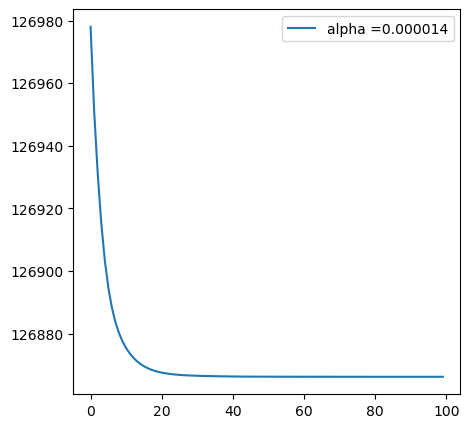

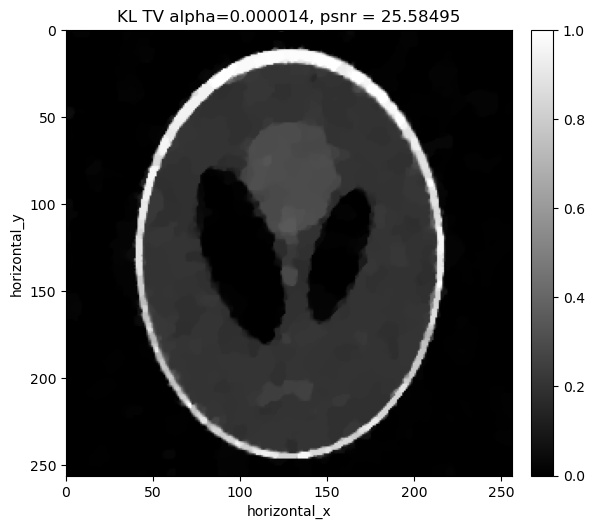

alpha=0.000014, psnr= 25.585
alpha=0.000016, psnr= 25.292


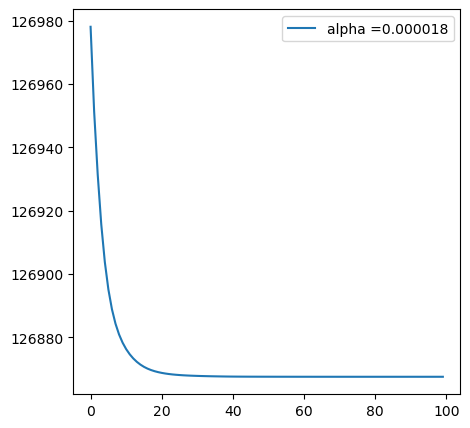

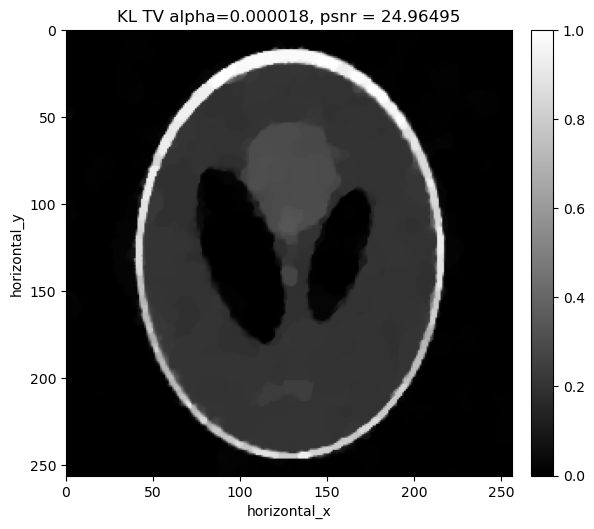

alpha=0.000018, psnr= 24.965
alpha=0.000021, psnr= 24.630


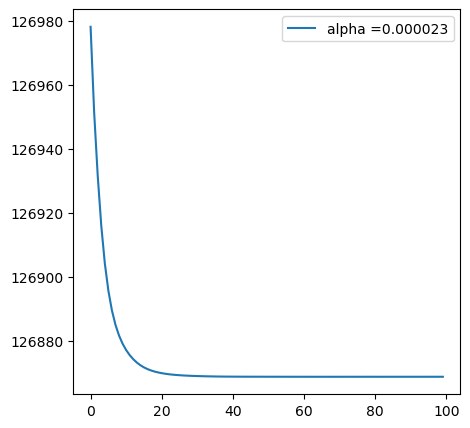

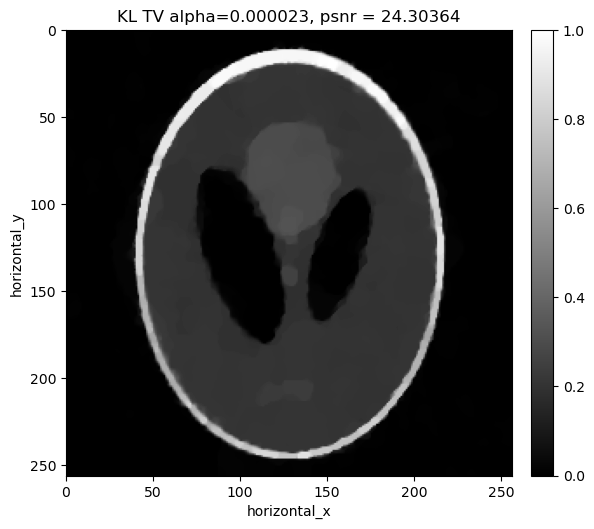

alpha=0.000023, psnr= 24.304
alpha=0.000025, psnr= 23.994


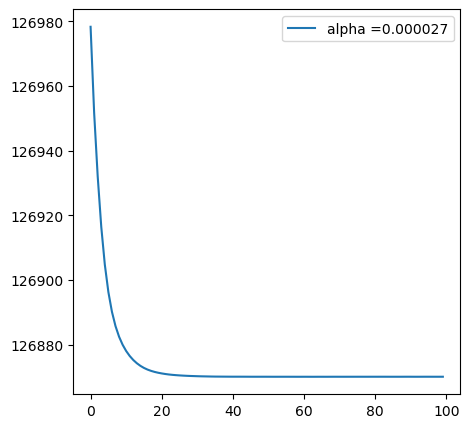

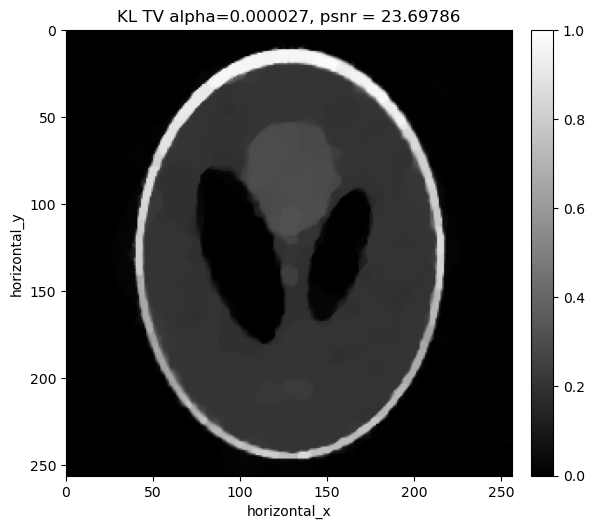

alpha=0.000027, psnr= 23.698
alpha=0.000029, psnr= 23.421


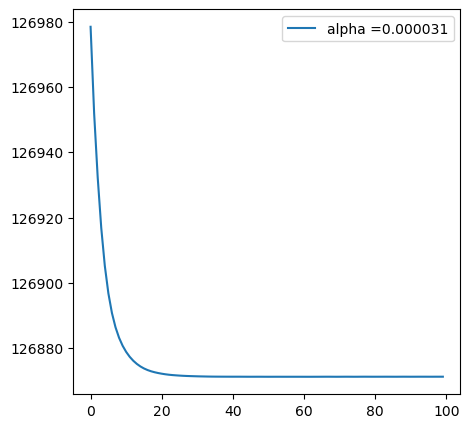

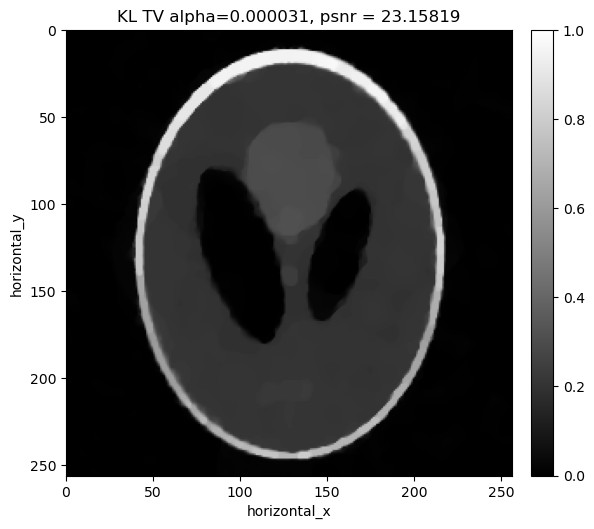

alpha=0.000031, psnr= 23.158
alpha=0.000033, psnr= 22.914


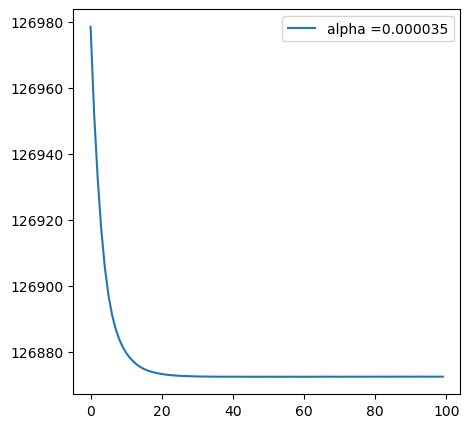

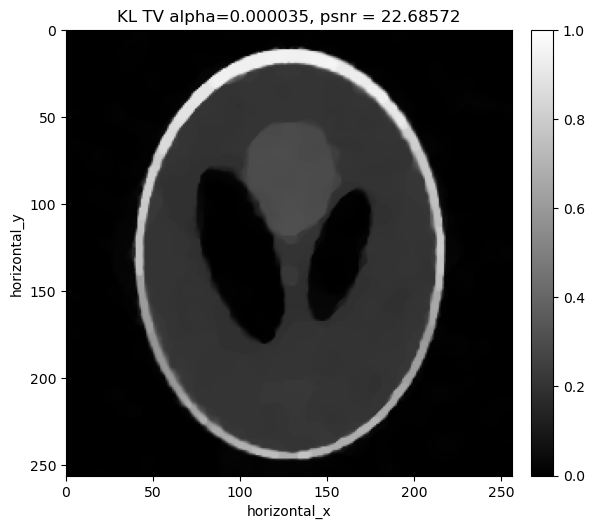

alpha=0.000035, psnr= 22.686
alpha=0.000037, psnr= 22.470


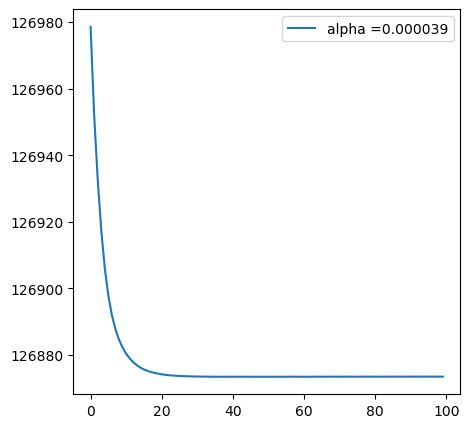

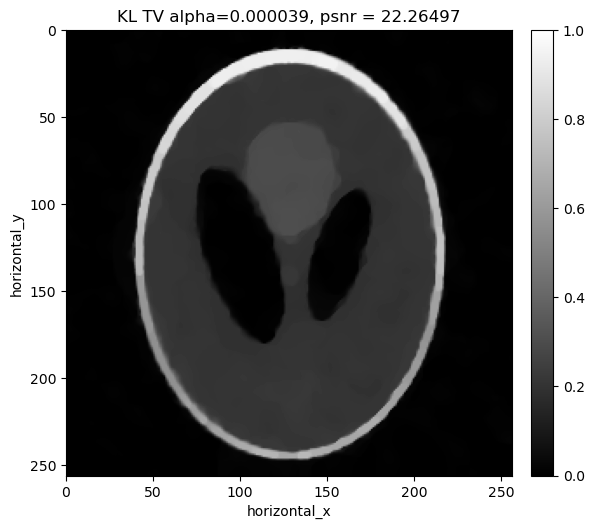

alpha=0.000039, psnr= 22.265
alpha=0.000042, psnr= 22.071


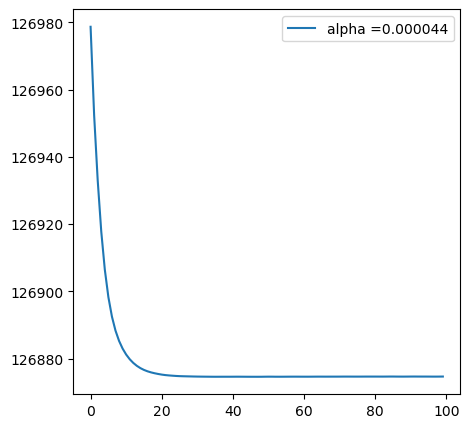

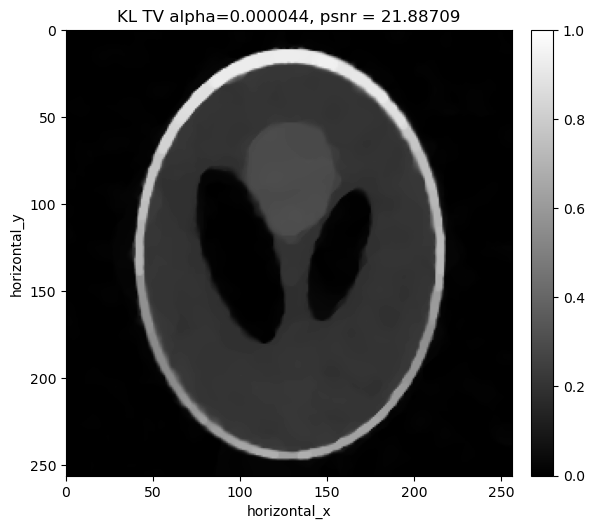

alpha=0.000044, psnr= 21.887
alpha=0.000046, psnr= 21.711


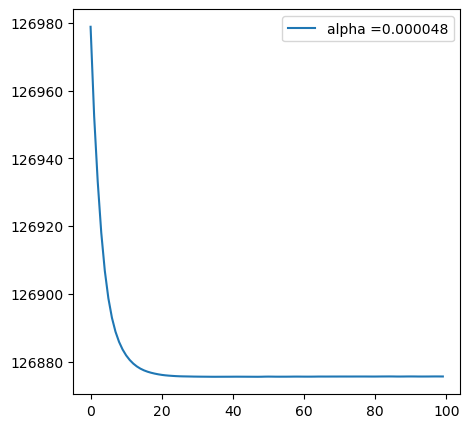

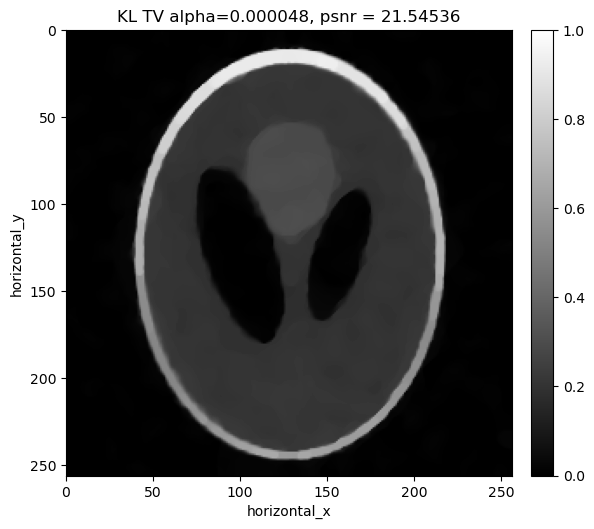

alpha=0.000048, psnr= 21.545
alpha=0.000050, psnr= 21.388


In [ ]:
# Selection of the best regularization parametr using KL TV - FISTA
alpha_min = 0.000005
alpha_max = 0.000045
alpha_n   = 20
alphas_kl    = np.linspace(alpha_min, alpha_max, alpha_n) 
modulo    = 2 #10 #how often to save reconstructions, for the different values of alpha

#Definition of the fidelity term
d2 = noisy_counts/background_counts
KL_pre = KL_prelog(d = d2)
f_KL = OperatorCompositionFunction(KL_pre, A)

#Initialize quantities
x0 = ig.allocate(0.0)
psnr_kl_tv_alpha = np.zeros_like(alphas_kl)
kl_max_psnr = 0

# Run the loop over the different values of alpha
for i in range(alpha_n):
    alpha = alphas_kl[i]
    # Defining the regularization term with the new alpha
    GTV = alpha*TotalVariation()
    # Setting up FISTA
    myFISTAKLTV = FISTA(f=f_KL, 
                  g=GTV, 
                  x_init=x0 ,
                  max_iteration=100, initial=ig.allocate(0))
    # Run FISTA
    myFISTAKLTV.run(100, verbose=0)
    recon_kl_tv = myFISTAKLTV.solution
    psnr_kl_tv_alpha[i] = psnr(phantom,recon_kl_tv, data_range = np.max(phantom))
    
    
    
    # Plot the reconstruction (one every "modulo")
    if i%modulo == 0:
        # plot the objective function
        plt.figure(figsize=(5,5))
        plt.plot( myFISTAKLTV.objective[1:],label="alpha =%7.6f" % (alpha))
        plt.legend(fontsize=10)
        
        # plot the reconstruction 
        show2D([recon_kl_tv], ["KL TV alpha=%7.6f, psnr = %7.5f" % (alpha,psnr_kl_tv_alpha[i])], \
        cmap=cmap,fix_range=(0,1), size=(10,10), origin='upper-left')
        
        
    # print the value of alpha and the obtained psnr of the reconstruction
    print("alpha=%7.6f, psnr= %5.3f" % (alpha,psnr_kl_tv_alpha[i]))
    
    # Save the best reconstruction
    if psnr_kl_tv_alpha[i]>kl_max_psnr:
        kl_max_psnr   = psnr_kl_tv_alpha[i]
        kl_best_recon = recon_kl_tv
        kl_best_alpha = alpha

In [ ]:
recon_kl_tv_fista = kl_best_recon
psnr_kl_tv_fista  = kl_max_psnr
alpha_kl_tv_fista = kl_best_alpha
print(psnr_kl_tv_fista)

25.788722991063565


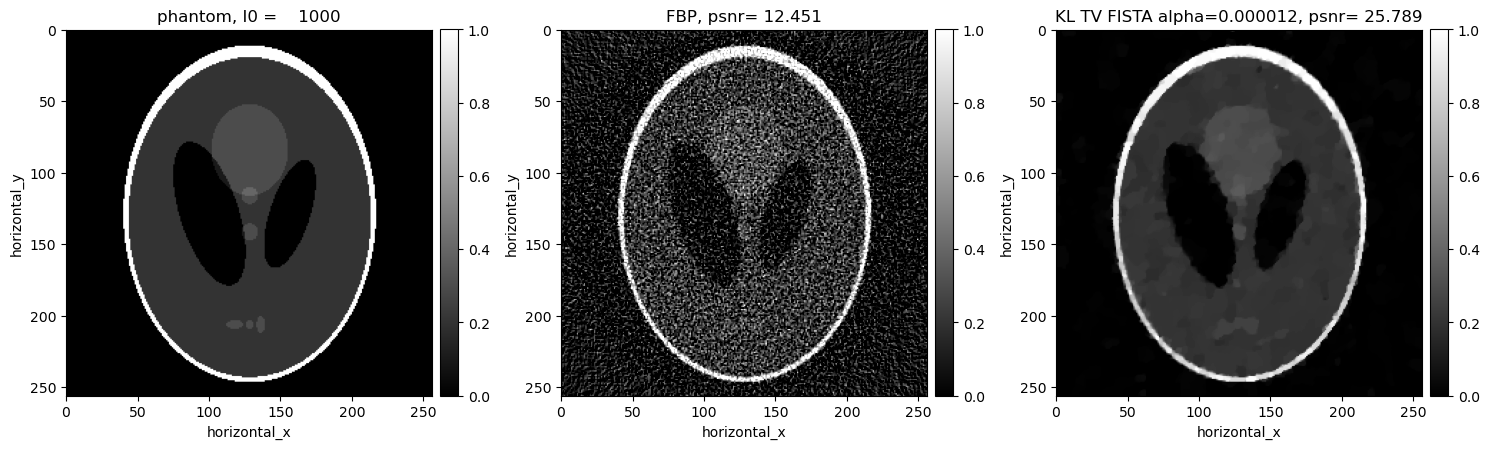

In [ ]:
show2D([phantom, recon_fbp, recon_kl_tv_fista ], ["phantom, I0 = %7.0f" % (background_counts), "FBP, psnr= %5.3f" % (psnr_fbp),\
    "KL TV FISTA alpha=%7.6f, psnr= %5.3f" % (alpha_kl_tv_fista,psnr_kl_tv_fista)], \
       cmap=cmap, fix_range =(0,1), num_cols=3, size=(15,10), origin='upper-left')


Text(0.5, 1.0, 'Reconstruction line horizontal=128 , I0 =    1000')

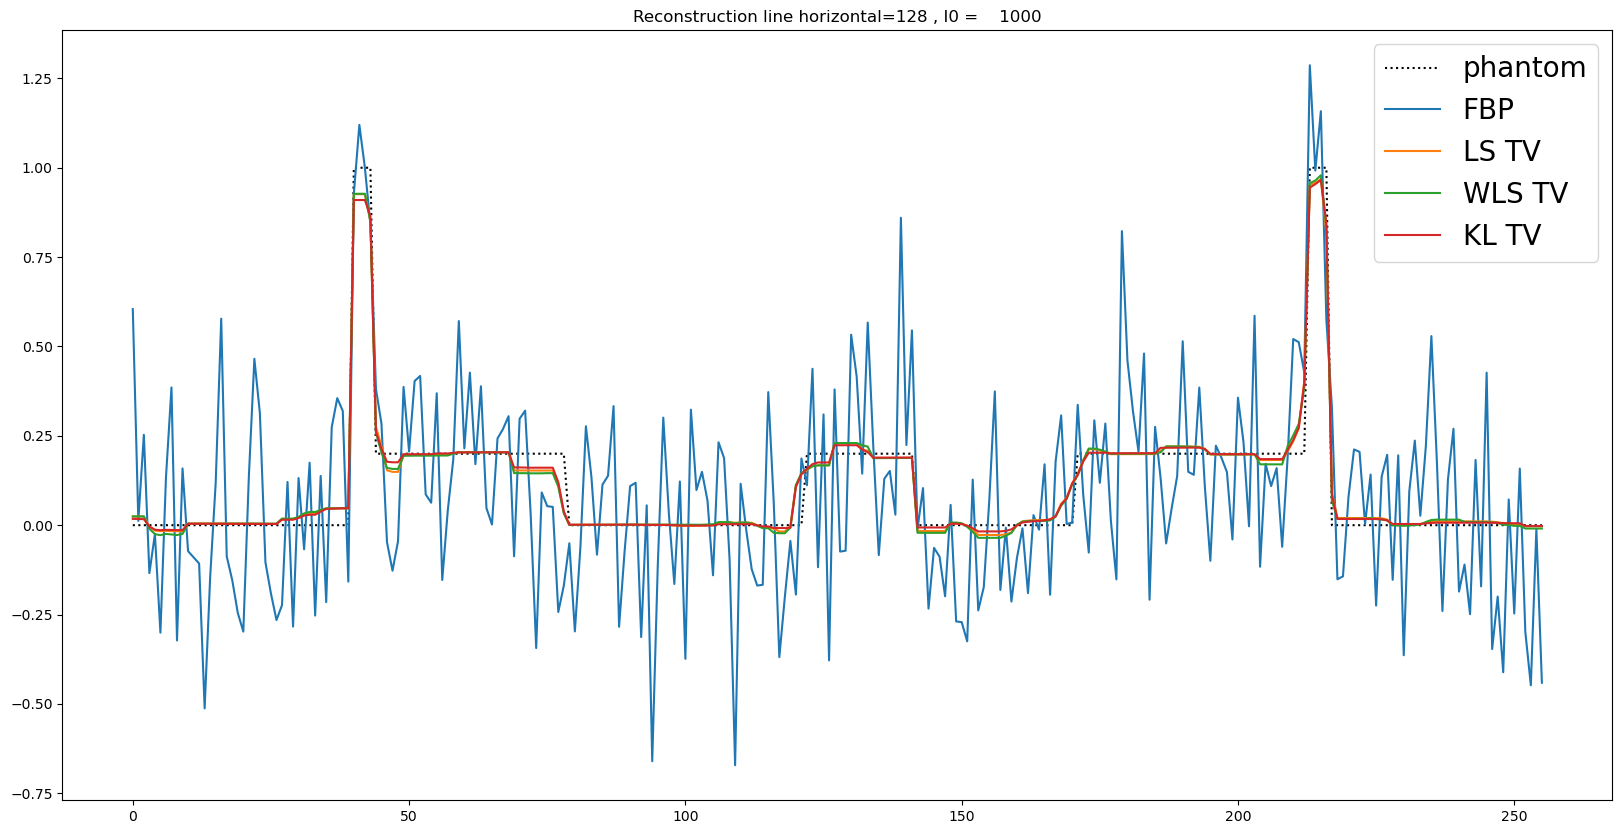

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(phantom.get_slice(horizontal_y=linenumy).as_array(),':k',label="phantom")
plt.plot(recon_fbp.get_slice(horizontal_y=linenumy).as_array(),label="FBP")
plt.plot(recon_ls_tv_fista.get_slice(horizontal_y=linenumy).as_array(),label="LS TV")
plt.plot(recon_wls_tv_fista.get_slice(horizontal_y=linenumy).as_array(),label="WLS TV")
plt.plot(recon_kl_tv_fista.get_slice(horizontal_y=linenumy).as_array(),label="KL TV")
plt.legend(fontsize=20)
plt.title("Reconstruction line horizontal=%3.0f , I0 = %7.f" % (linenumy,background_counts))


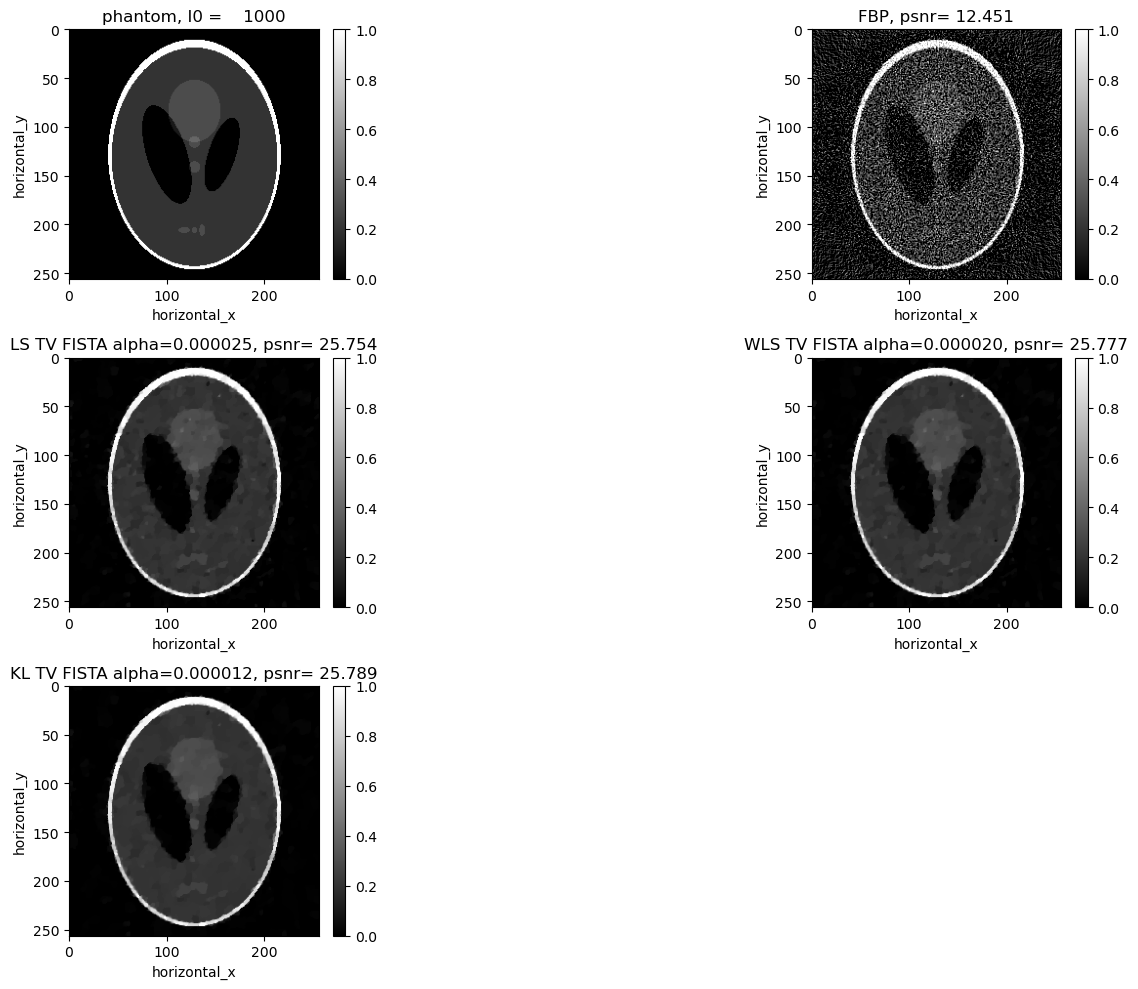

In [ ]:
show2D([phantom, recon_fbp, recon_wls_tv_fista,recon_wls_tv_fista, recon_kl_tv_fista ], ["phantom, I0 = %7.0f" % (background_counts), "FBP, psnr= %5.3f" % (psnr_fbp),\
    "LS TV FISTA alpha=%7.6f, psnr= %5.3f" % (alpha_ls_tv_fista,psnr_ls_tv_fista),\
    "WLS TV FISTA alpha=%7.6f, psnr= %5.3f" % (alpha_wls_tv_fista,psnr_wls_tv_fista), \
    "KL TV FISTA alpha=%7.6f, psnr= %5.3f" % (alpha_kl_tv_fista,psnr_kl_tv_fista)], \
       cmap=cmap, fix_range =(0,1), num_cols=2, size=(15,10), origin='upper-left')


Text(0.5, 1.0, 'PSNR for different values of alpha, I0 =    1000')

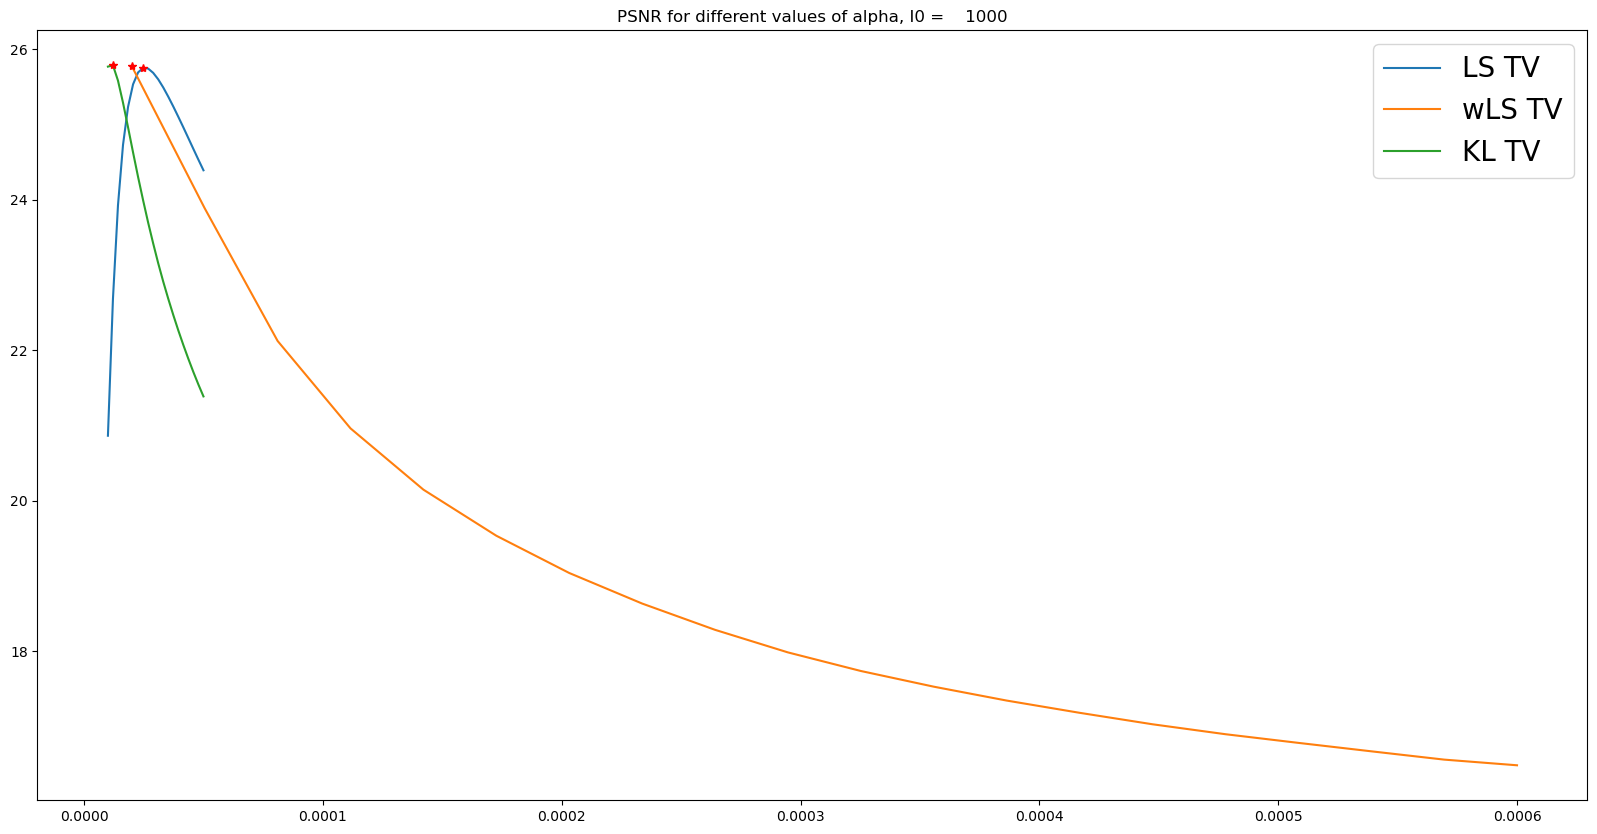

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(alphas_ls,psnr_ls_tv_alpha,label="LS TV")
plt.plot(alphas_wls,psnr_wls_tv_alpha,label="wLS TV")
plt.plot(alphas_kl,psnr_kl_tv_alpha,label="KL TV")
plt.plot(alpha_ls_tv_fista, psnr_ls_tv_fista, '*r')
plt.plot(alpha_wls_tv_fista, psnr_wls_tv_fista, '*r')
plt.plot(alpha_kl_tv_fista, psnr_kl_tv_fista, '*r')
plt.legend(fontsize=20)
plt.title("PSNR for different values of alpha, I0 = %7.f" % (background_counts))


How we want to compare the results with the ones obtained using the sinogram without the noise

In [ ]:
# FBP
recon_fbp_no_noise = fbp(sino)
psnr_fbp_no_noise = psnr(phantom,recon_fbp_no_noise)


In [ ]:
# LS
f5 = LeastSquares(A, sino)
gd_LS_no_noise = GD(x_init=ig.allocate(), objective_function=f5, step_size=None, 
            max_iteration=1000, update_objective_interval = 10)
gd_LS_no_noise.run(100, verbose=1)
recon_ls_no_noise = gd_LS_no_noise.solution
psnr_ls_no_noise  = psnr(phantom,recon_ls_no_noise, data_range = np.max(phantom))

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     


AttributeError: 'GD' object has no attribute 'objective_function'

In [ ]:
# WLS
weights2 = counts/background_counts
c2 = DataContainer(weights2)
print(c.shape)
f6 = LeastSquares(A, sino, 1,c2)
gd_wls_no_noise = GD(x_init=ig.allocate(), objective_function=f6, step_size=None, 
            max_iteration=1000, update_objective_interval = 10)
gd_wls_no_noise.run(100, verbose=1)
recon_wls_no_noise = gd_wls_no_noise.solution
psnr_wls_no_noise  = psnr(phantom,recon_wls_no_noise, data_range = np.max(phantom))

In [ ]:
#KL
F2 = KullbackLeibler(b = sino)
G = ZeroFunction()
max_iterations = 500 
pdhg_no_noise = PDHG(f = F2, g = G,operator = K,
            max_iteration = max_iterations, update_objective_interval = 10)
pdhg_no_noise.run(verbose = 2, print_interval=10)
recon_KL_no_noise = pdhg_no_noise.solution
psnr_KL_no_noise = psnr(phantom,recon_KL_no_noise,np.max(phantom))

In [ ]:
title2 = 'no noise'
show2D([phantom, recon_fbp_no_noise, recon_ls_no_noise,recon_sirt_no_noise,recon_wls_no_noise,recon_KL_no_noise], ['phantom', "FBP, psnr= %5.3f" % (psnr_fbp_no_noise),"LS, psnr= %5.3f" % (psnr_ls_no_noise),"SIRT, psnr= %5.3f" % (psnr_sirt_no_noise),"WLS, psnr= %5.3f" % (psnr_wls_no_noise),"KL post log, psnr= %5.3f" % (psnr_KL_no_noise)], \
       cmap=cmap, fix_range =(0,1), num_cols=3, size=(15,10), origin='upper-left')
